---

title: Prediction using CNN-LSTM
description: Stock Market Prediction using CNN-LSTM method 


---

# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

# Data Preprocessing and Analysis

In [4]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [5]:
import requests
import csv
from tqdm import tqdm

# Get API key from environment variable
key = os.getenv('ALPHA_VANTAGE_API_KEY')

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "volume"]
    df['date'] = date
    return df

In [6]:


cv1 = request_stock_price_list('IBM', 'full', key)
print(cv1.head)
cv1.to_csv('data.csv')

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 6546/6546 [01:04<00:00, 100.71it/s]

<bound method NDFrame.head of           open      high       low     close    volume        date
0     309.6800  310.0000  302.6301  306.3800   5070773  2025-11-07
1     306.7500  315.4400  301.0900  312.4200   6818521  2025-11-06
2     301.3800  307.2000  299.7100  306.7700   4633195  2025-11-05
3     300.0000  303.1700  296.0000  300.8500   5677330  2025-11-04
4     308.0000  312.1411  304.2300  304.7300   4957958  2025-11-03
...        ...       ...       ...       ...       ...         ...
6541   92.7500   92.9400   90.1900   90.2500  13737600  1999-11-05
6542   94.4400   94.4400   90.0000   91.5600  16697600  1999-11-04
6543   95.8700   95.9400   93.5000   94.3700  10369100  1999-11-03
6544   96.7500   96.8100   93.6900   94.8100  11105400  1999-11-02
6545   98.5000   98.8100   96.3700   96.7500   9551800  1999-11-01

[6546 rows x 6 columns]>


Then the datasets are loaded

In [2]:
# Load single-stock data from data.csv (user requested)
import os

data_path = './data.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"{data_path} not found. Make sure data.csv is in the notebook folder.")

# Read data.csv
data = pd.read_csv(data_path)

# Normalize column names if necessary
data.columns = [c.strip() for c in data.columns]

# Ensure Date and Close columns exist
if 'Date' not in data.columns and 'date' in data.columns:
    data.rename(columns={'date':'Date'}, inplace=True)
if 'Close' not in data.columns and 'close' in data.columns:
    data.rename(columns={'close':'Close'}, inplace=True)

# Parse dates and sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

print(f"Loaded data.csv with {len(data)} rows, Date range: {data['Date'].min()} to {data['Date'].max()}")
print(data.head())

Loaded data.csv with 6546 rows, Date range: 1999-11-01 00:00:00 to 2025-11-07 00:00:00
   Unnamed: 0   open   high    low  Close    volume       Date
0        6545  98.50  98.81  96.37  96.75   9551800 1999-11-01
1        6544  96.75  96.81  93.69  94.81  11105400 1999-11-02
2        6543  95.87  95.94  93.50  94.37  10369100 1999-11-03
3        6542  94.44  94.44  90.00  91.56  16697600 1999-11-04
4        6541  92.75  92.94  90.19  90.25  13737600 1999-11-05


In [13]:
# (Duplicate loader) read data.csv to avoid using NIFTY folder
import os

data_path = './data.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"{data_path} not found. Make sure data.csv is in the notebook folder.")

data = pd.read_csv(data_path)

# Normalize column names
data.columns = [c.strip() for c in data.columns]
if 'date' in data.columns and 'Date' not in data.columns:
    data.rename(columns={'date':'Date'}, inplace=True)
if 'close' in data.columns and 'Close' not in data.columns:
    data.rename(columns={'close':'Close'}, inplace=True)

# Parse dates and sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

print(f"Loaded data.csv with {len(data)} rows, Date range: {data['Date'].min()} to {data['Date'].max()}")
data.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31656\2578453567.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dfs, ignore_index=True)


Total number of stocks: 51
Date range: 2000-01-03 00:00:00 to 2021-04-30 00:00:00
Total number of records: 470384


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ASIANPAINT,EQ,361.20,370.00,390.00,370.00,385.00,381.65,380.54,3318,1.262617e+11,NaN,NaN,NaN
1,2000-01-03,AXISBANK,EQ,24.70,26.70,26.70,26.70,26.70,26.70,26.70,112100,2.993070e+11,NaN,NaN,NaN
2,2000-01-03,BAJFINANCE,EQ,46.95,49.45,50.75,46.50,50.75,50.75,50.05,7600,3.803800e+10,NaN,NaN,NaN
3,2000-01-03,BPCL,EQ,381.20,405.00,407.00,393.05,397.75,399.25,399.32,8720,3.482029e+11,NaN,NaN,NaN
4,2000-01-03,BRITANNIA,EQ,703.25,705.00,759.50,705.00,758.00,756.90,741.01,7512,5.566488e+11,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6546 entries, 0 to 6545
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6546 non-null   int64  
 1   open        6546 non-null   float64
 2   high        6546 non-null   float64
 3   low         6546 non-null   float64
 4   close       6546 non-null   float64
 5   volume      6546 non-null   int64  
 6   date        6546 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 358.1+ KB


In [9]:
data.describe()

,Unnamed: 0,open,high,low,close,volume
count,6546.000000,6546.000000,6546.000000,6546.000000,6546.000000,6.546000e+03
mean,3272.500000,136.509333,137.769733,135.336554,136.591623,5.857900e+06
std,1889.811763,43.040107,43.306710,42.810311,43.112112,3.284825e+06
min,0.000000,54.650000,56.700000,54.010000,55.070000,1.027500e+06
25%,1636.250000,103.425000,105.000000,101.955000,103.325000,3.705910e+06
50%,3272.500000,130.750000,132.105000,129.770000,130.865000,4.999350e+06
75%,4908.750000,161.662500,162.655000,160.455025,161.785000,7.049950e+06
max,6545.000000,312.790000,319.350000,311.410000,313.090000,4.120730e+07


In [10]:
data.isnull().sum()

Unnamed: 0    0
open          0
high          0
low           0
close         0
volume        0
date          0
dtype: int64

Filling null columns with mean values....

In [11]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

TypeError: Could not convert ['2025-11-072025-11-062025-11-052025-11-042025-11-032025-10-312025-10-302025-10-292025-10-282025-10-272025-10-242025-10-232025-10-222025-10-212025-10-202025-10-172025-10-162025-10-152025-10-142025-10-132025-10-102025-10-092025-10-082025-10-072025-10-062025-10-032025-10-022025-10-012025-09-302025-09-292025-09-262025-09-252025-09-242025-09-232025-09-222025-09-192025-09-182025-09-172025-09-162025-09-152025-09-122025-09-112025-09-102025-09-092025-09-082025-09-052025-09-042025-09-032025-09-022025-08-292025-08-282025-08-272025-08-262025-08-252025-08-222025-08-212025-08-202025-08-192025-08-182025-08-152025-08-142025-08-132025-08-122025-08-112025-08-082025-08-072025-08-062025-08-052025-08-042025-08-012025-07-312025-07-302025-07-292025-07-282025-07-252025-07-242025-07-232025-07-222025-07-212025-07-182025-07-172025-07-162025-07-152025-07-142025-07-112025-07-102025-07-092025-07-082025-07-072025-07-032025-07-022025-07-012025-06-302025-06-272025-06-262025-06-252025-06-242025-06-232025-06-202025-06-182025-06-172025-06-162025-06-132025-06-122025-06-112025-06-102025-06-092025-06-062025-06-052025-06-042025-06-032025-06-022025-05-302025-05-292025-05-282025-05-272025-05-232025-05-222025-05-212025-05-202025-05-192025-05-162025-05-152025-05-142025-05-132025-05-122025-05-092025-05-082025-05-072025-05-062025-05-052025-05-022025-05-012025-04-302025-04-292025-04-282025-04-252025-04-242025-04-232025-04-222025-04-212025-04-172025-04-162025-04-152025-04-142025-04-112025-04-102025-04-092025-04-082025-04-072025-04-042025-04-032025-04-022025-04-012025-03-312025-03-282025-03-272025-03-262025-03-252025-03-242025-03-212025-03-202025-03-192025-03-182025-03-172025-03-142025-03-132025-03-122025-03-112025-03-102025-03-072025-03-062025-03-052025-03-042025-03-032025-02-282025-02-272025-02-262025-02-252025-02-242025-02-212025-02-202025-02-192025-02-182025-02-142025-02-132025-02-122025-02-112025-02-102025-02-072025-02-062025-02-052025-02-042025-02-032025-01-312025-01-302025-01-292025-01-282025-01-272025-01-242025-01-232025-01-222025-01-212025-01-172025-01-162025-01-152025-01-142025-01-132025-01-102025-01-082025-01-072025-01-062025-01-032025-01-022024-12-312024-12-302024-12-272024-12-262024-12-242024-12-232024-12-202024-12-192024-12-182024-12-172024-12-162024-12-132024-12-122024-12-112024-12-102024-12-092024-12-062024-12-052024-12-042024-12-032024-12-022024-11-292024-11-272024-11-262024-11-252024-11-222024-11-212024-11-202024-11-192024-11-182024-11-152024-11-142024-11-132024-11-122024-11-112024-11-082024-11-072024-11-062024-11-052024-11-042024-11-012024-10-312024-10-302024-10-292024-10-282024-10-252024-10-242024-10-232024-10-222024-10-212024-10-182024-10-172024-10-162024-10-152024-10-142024-10-112024-10-102024-10-092024-10-082024-10-072024-10-042024-10-032024-10-022024-10-012024-09-302024-09-272024-09-262024-09-252024-09-242024-09-232024-09-202024-09-192024-09-182024-09-172024-09-162024-09-132024-09-122024-09-112024-09-102024-09-092024-09-062024-09-052024-09-042024-09-032024-08-302024-08-292024-08-282024-08-272024-08-262024-08-232024-08-222024-08-212024-08-202024-08-192024-08-162024-08-152024-08-142024-08-132024-08-122024-08-092024-08-082024-08-072024-08-062024-08-052024-08-022024-08-012024-07-312024-07-302024-07-292024-07-262024-07-252024-07-242024-07-232024-07-222024-07-192024-07-182024-07-172024-07-162024-07-152024-07-122024-07-112024-07-102024-07-092024-07-082024-07-052024-07-032024-07-022024-07-012024-06-282024-06-272024-06-262024-06-252024-06-242024-06-212024-06-202024-06-182024-06-172024-06-142024-06-132024-06-122024-06-112024-06-102024-06-072024-06-062024-06-052024-06-042024-06-032024-05-312024-05-302024-05-292024-05-282024-05-242024-05-232024-05-222024-05-212024-05-202024-05-172024-05-162024-05-152024-05-142024-05-132024-05-102024-05-092024-05-082024-05-072024-05-062024-05-032024-05-022024-05-012024-04-302024-04-292024-04-262024-04-252024-04-242024-04-232024-04-222024-04-192024-04-182024-04-172024-04-162024-04-152024-04-122024-04-112024-04-102024-04-092024-04-082024-04-052024-04-042024-04-032024-04-022024-04-012024-03-282024-03-272024-03-262024-03-252024-03-222024-03-212024-03-202024-03-192024-03-182024-03-152024-03-142024-03-132024-03-122024-03-112024-03-082024-03-072024-03-062024-03-052024-03-042024-03-012024-02-292024-02-282024-02-272024-02-262024-02-232024-02-222024-02-212024-02-202024-02-162024-02-152024-02-142024-02-132024-02-122024-02-092024-02-082024-02-072024-02-062024-02-052024-02-022024-02-012024-01-312024-01-302024-01-292024-01-262024-01-252024-01-242024-01-232024-01-222024-01-192024-01-182024-01-172024-01-162024-01-122024-01-112024-01-102024-01-092024-01-082024-01-052024-01-042024-01-032024-01-022023-12-292023-12-282023-12-272023-12-262023-12-222023-12-212023-12-202023-12-192023-12-182023-12-152023-12-142023-12-132023-12-122023-12-112023-12-082023-12-072023-12-062023-12-052023-12-042023-12-012023-11-302023-11-292023-11-282023-11-272023-11-242023-11-222023-11-212023-11-202023-11-172023-11-162023-11-152023-11-142023-11-132023-11-102023-11-092023-11-082023-11-072023-11-062023-11-032023-11-022023-11-012023-10-312023-10-302023-10-272023-10-262023-10-252023-10-242023-10-232023-10-202023-10-192023-10-182023-10-172023-10-162023-10-132023-10-122023-10-112023-10-102023-10-092023-10-062023-10-052023-10-042023-10-032023-10-022023-09-292023-09-282023-09-272023-09-262023-09-252023-09-222023-09-212023-09-202023-09-192023-09-182023-09-152023-09-142023-09-132023-09-122023-09-112023-09-082023-09-072023-09-062023-09-052023-09-012023-08-312023-08-302023-08-292023-08-282023-08-252023-08-242023-08-232023-08-222023-08-212023-08-182023-08-172023-08-162023-08-152023-08-142023-08-112023-08-102023-08-092023-08-082023-08-072023-08-042023-08-032023-08-022023-08-012023-07-312023-07-282023-07-272023-07-262023-07-252023-07-242023-07-212023-07-202023-07-192023-07-182023-07-172023-07-142023-07-132023-07-122023-07-112023-07-102023-07-072023-07-062023-07-052023-07-032023-06-302023-06-292023-06-282023-06-272023-06-262023-06-232023-06-222023-06-212023-06-202023-06-162023-06-152023-06-142023-06-132023-06-122023-06-092023-06-082023-06-072023-06-062023-06-052023-06-022023-06-012023-05-312023-05-302023-05-262023-05-252023-05-242023-05-232023-05-222023-05-192023-05-182023-05-172023-05-162023-05-152023-05-122023-05-112023-05-102023-05-092023-05-082023-05-052023-05-042023-05-032023-05-022023-05-012023-04-282023-04-272023-04-262023-04-252023-04-242023-04-212023-04-202023-04-192023-04-182023-04-172023-04-142023-04-132023-04-122023-04-112023-04-102023-04-062023-04-052023-04-042023-04-032023-03-312023-03-302023-03-292023-03-282023-03-272023-03-242023-03-232023-03-222023-03-212023-03-202023-03-172023-03-162023-03-152023-03-142023-03-132023-03-102023-03-092023-03-082023-03-072023-03-062023-03-032023-03-022023-03-012023-02-282023-02-272023-02-242023-02-232023-02-222023-02-212023-02-172023-02-162023-02-152023-02-142023-02-132023-02-102023-02-092023-02-082023-02-072023-02-062023-02-032023-02-022023-02-012023-01-312023-01-302023-01-272023-01-262023-01-252023-01-242023-01-232023-01-202023-01-192023-01-182023-01-172023-01-132023-01-122023-01-112023-01-102023-01-092023-01-062023-01-052023-01-042023-01-032022-12-302022-12-292022-12-282022-12-272022-12-232022-12-222022-12-212022-12-202022-12-192022-12-162022-12-152022-12-142022-12-132022-12-122022-12-092022-12-082022-12-072022-12-062022-12-052022-12-022022-12-012022-11-302022-11-292022-11-282022-11-252022-11-232022-11-222022-11-212022-11-182022-11-172022-11-162022-11-152022-11-142022-11-112022-11-102022-11-092022-11-082022-11-072022-11-042022-11-032022-11-022022-11-012022-10-312022-10-282022-10-272022-10-262022-10-252022-10-242022-10-212022-10-202022-10-192022-10-182022-10-172022-10-142022-10-132022-10-122022-10-112022-10-102022-10-072022-10-062022-10-052022-10-042022-10-032022-09-302022-09-292022-09-282022-09-272022-09-262022-09-232022-09-222022-09-212022-09-202022-09-192022-09-162022-09-152022-09-142022-09-132022-09-122022-09-092022-09-082022-09-072022-09-062022-09-022022-09-012022-08-312022-08-302022-08-292022-08-262022-08-252022-08-242022-08-232022-08-222022-08-192022-08-182022-08-172022-08-162022-08-152022-08-122022-08-112022-08-102022-08-092022-08-082022-08-052022-08-042022-08-032022-08-022022-08-012022-07-292022-07-282022-07-272022-07-262022-07-252022-07-222022-07-212022-07-202022-07-192022-07-182022-07-152022-07-142022-07-132022-07-122022-07-112022-07-082022-07-072022-07-062022-07-052022-07-012022-06-302022-06-292022-06-282022-06-272022-06-242022-06-232022-06-222022-06-212022-06-172022-06-162022-06-152022-06-142022-06-132022-06-102022-06-092022-06-082022-06-072022-06-062022-06-032022-06-022022-06-012022-05-312022-05-272022-05-262022-05-252022-05-242022-05-232022-05-202022-05-192022-05-182022-05-172022-05-162022-05-132022-05-122022-05-112022-05-102022-05-092022-05-062022-05-052022-05-042022-05-032022-05-022022-04-292022-04-282022-04-272022-04-262022-04-252022-04-222022-04-212022-04-202022-04-192022-04-182022-04-142022-04-132022-04-122022-04-112022-04-082022-04-072022-04-062022-04-052022-04-042022-04-012022-03-312022-03-302022-03-292022-03-282022-03-252022-03-242022-03-232022-03-222022-03-212022-03-182022-03-172022-03-162022-03-152022-03-142022-03-112022-03-102022-03-092022-03-082022-03-072022-03-042022-03-032022-03-022022-03-012022-02-282022-02-252022-02-242022-02-232022-02-222022-02-182022-02-172022-02-162022-02-152022-02-142022-02-112022-02-102022-02-092022-02-082022-02-072022-02-042022-02-032022-02-022022-02-012022-01-312022-01-282022-01-272022-01-262022-01-252022-01-242022-01-212022-01-202022-01-192022-01-182022-01-142022-01-132022-01-122022-01-112022-01-102022-01-072022-01-062022-01-052022-01-042022-01-032021-12-312021-12-302021-12-292021-12-282021-12-272021-12-232021-12-222021-12-212021-12-202021-12-172021-12-162021-12-152021-12-142021-12-132021-12-102021-12-092021-12-082021-12-072021-12-062021-12-032021-12-022021-12-012021-11-302021-11-292021-11-262021-11-242021-11-232021-11-222021-11-192021-11-182021-11-172021-11-162021-11-152021-11-122021-11-112021-11-102021-11-092021-11-082021-11-052021-11-042021-11-032021-11-022021-11-012021-10-292021-10-282021-10-272021-10-262021-10-252021-10-222021-10-212021-10-202021-10-192021-10-182021-10-152021-10-142021-10-132021-10-122021-10-112021-10-082021-10-072021-10-062021-10-052021-10-042021-10-012021-09-302021-09-292021-09-282021-09-272021-09-242021-09-232021-09-222021-09-212021-09-202021-09-172021-09-162021-09-152021-09-142021-09-132021-09-102021-09-092021-09-082021-09-072021-09-032021-09-022021-09-012021-08-312021-08-302021-08-272021-08-262021-08-252021-08-242021-08-232021-08-202021-08-192021-08-182021-08-172021-08-162021-08-132021-08-122021-08-112021-08-102021-08-092021-08-062021-08-052021-08-042021-08-032021-08-022021-07-302021-07-292021-07-282021-07-272021-07-262021-07-232021-07-222021-07-212021-07-202021-07-192021-07-162021-07-152021-07-142021-07-132021-07-122021-07-092021-07-082021-07-072021-07-062021-07-022021-07-012021-06-302021-06-292021-06-282021-06-252021-06-242021-06-232021-06-222021-06-212021-06-182021-06-172021-06-162021-06-152021-06-142021-06-112021-06-102021-06-092021-06-082021-06-072021-06-042021-06-032021-06-022021-06-012021-05-282021-05-272021-05-262021-05-252021-05-242021-05-212021-05-202021-05-192021-05-182021-05-172021-05-142021-05-132021-05-122021-05-112021-05-102021-05-072021-05-062021-05-052021-05-042021-05-032021-04-302021-04-292021-04-282021-04-272021-04-262021-04-232021-04-222021-04-212021-04-202021-04-192021-04-162021-04-152021-04-142021-04-132021-04-122021-04-092021-04-082021-04-072021-04-062021-04-052021-04-012021-03-312021-03-302021-03-292021-03-262021-03-252021-03-242021-03-232021-03-222021-03-192021-03-182021-03-172021-03-162021-03-152021-03-122021-03-112021-03-102021-03-092021-03-082021-03-052021-03-042021-03-032021-03-022021-03-012021-02-262021-02-252021-02-242021-02-232021-02-222021-02-192021-02-182021-02-172021-02-162021-02-122021-02-112021-02-102021-02-092021-02-082021-02-052021-02-042021-02-032021-02-022021-02-012021-01-292021-01-282021-01-272021-01-262021-01-252021-01-222021-01-212021-01-202021-01-192021-01-152021-01-142021-01-132021-01-122021-01-112021-01-082021-01-072021-01-062021-01-052021-01-042020-12-312020-12-302020-12-292020-12-282020-12-242020-12-232020-12-222020-12-212020-12-182020-12-172020-12-162020-12-152020-12-142020-12-112020-12-102020-12-092020-12-082020-12-072020-12-042020-12-032020-12-022020-12-012020-11-302020-11-272020-11-252020-11-242020-11-232020-11-202020-11-192020-11-182020-11-172020-11-162020-11-132020-11-122020-11-112020-11-102020-11-092020-11-062020-11-052020-11-042020-11-032020-11-022020-10-302020-10-292020-10-282020-10-272020-10-262020-10-232020-10-222020-10-212020-10-202020-10-192020-10-162020-10-152020-10-142020-10-132020-10-122020-10-092020-10-082020-10-072020-10-062020-10-052020-10-022020-10-012020-09-302020-09-292020-09-282020-09-252020-09-242020-09-232020-09-222020-09-212020-09-182020-09-172020-09-162020-09-152020-09-142020-09-112020-09-102020-09-092020-09-082020-09-042020-09-032020-09-022020-09-012020-08-312020-08-282020-08-272020-08-262020-08-252020-08-242020-08-212020-08-202020-08-192020-08-182020-08-172020-08-142020-08-132020-08-122020-08-112020-08-102020-08-072020-08-062020-08-052020-08-042020-08-032020-07-312020-07-302020-07-292020-07-282020-07-272020-07-242020-07-232020-07-222020-07-212020-07-202020-07-172020-07-162020-07-152020-07-142020-07-132020-07-102020-07-092020-07-082020-07-072020-07-062020-07-022020-07-012020-06-302020-06-292020-06-262020-06-252020-06-242020-06-232020-06-222020-06-192020-06-182020-06-172020-06-162020-06-152020-06-122020-06-112020-06-102020-06-092020-06-082020-06-052020-06-042020-06-032020-06-022020-06-012020-05-292020-05-282020-05-272020-05-262020-05-222020-05-212020-05-202020-05-192020-05-182020-05-152020-05-142020-05-132020-05-122020-05-112020-05-082020-05-072020-05-062020-05-052020-05-042020-05-012020-04-302020-04-292020-04-282020-04-272020-04-242020-04-232020-04-222020-04-212020-04-202020-04-172020-04-162020-04-152020-04-142020-04-132020-04-092020-04-082020-04-072020-04-062020-04-032020-04-022020-04-012020-03-312020-03-302020-03-272020-03-262020-03-252020-03-242020-03-232020-03-202020-03-192020-03-182020-03-172020-03-162020-03-132020-03-122020-03-112020-03-102020-03-092020-03-062020-03-052020-03-042020-03-032020-03-022020-02-282020-02-272020-02-262020-02-252020-02-242020-02-212020-02-202020-02-192020-02-182020-02-142020-02-132020-02-122020-02-112020-02-102020-02-072020-02-062020-02-052020-02-042020-02-032020-01-312020-01-302020-01-292020-01-282020-01-272020-01-242020-01-232020-01-222020-01-212020-01-172020-01-162020-01-152020-01-142020-01-132020-01-102020-01-092020-01-082020-01-072020-01-062020-01-032020-01-022019-12-312019-12-302019-12-272019-12-262019-12-242019-12-232019-12-202019-12-192019-12-182019-12-172019-12-162019-12-132019-12-122019-12-112019-12-102019-12-092019-12-062019-12-052019-12-042019-12-032019-12-022019-11-292019-11-272019-11-262019-11-252019-11-222019-11-212019-11-202019-11-192019-11-182019-11-152019-11-142019-11-132019-11-122019-11-112019-11-082019-11-072019-11-062019-11-052019-11-042019-11-012019-10-312019-10-302019-10-292019-10-282019-10-252019-10-242019-10-232019-10-222019-10-212019-10-182019-10-172019-10-162019-10-152019-10-142019-10-112019-10-102019-10-092019-10-082019-10-072019-10-042019-10-032019-10-022019-10-012019-09-302019-09-272019-09-262019-09-252019-09-242019-09-232019-09-202019-09-192019-09-182019-09-172019-09-162019-09-132019-09-122019-09-112019-09-102019-09-092019-09-062019-09-052019-09-042019-09-032019-08-302019-08-292019-08-282019-08-272019-08-262019-08-232019-08-222019-08-212019-08-202019-08-192019-08-162019-08-152019-08-142019-08-132019-08-122019-08-092019-08-082019-08-072019-08-062019-08-052019-08-022019-08-012019-07-312019-07-302019-07-292019-07-262019-07-252019-07-242019-07-232019-07-222019-07-192019-07-182019-07-172019-07-162019-07-152019-07-122019-07-112019-07-102019-07-092019-07-082019-07-052019-07-032019-07-022019-07-012019-06-282019-06-272019-06-262019-06-252019-06-242019-06-212019-06-202019-06-192019-06-182019-06-172019-06-142019-06-132019-06-122019-06-112019-06-102019-06-072019-06-062019-06-052019-06-042019-06-032019-05-312019-05-302019-05-292019-05-282019-05-242019-05-232019-05-222019-05-212019-05-202019-05-172019-05-162019-05-152019-05-142019-05-132019-05-102019-05-092019-05-082019-05-072019-05-062019-05-032019-05-022019-05-012019-04-302019-04-292019-04-262019-04-252019-04-242019-04-232019-04-222019-04-182019-04-172019-04-162019-04-152019-04-122019-04-112019-04-102019-04-092019-04-082019-04-052019-04-042019-04-032019-04-022019-04-012019-03-292019-03-282019-03-272019-03-262019-03-252019-03-222019-03-212019-03-202019-03-192019-03-182019-03-152019-03-142019-03-132019-03-122019-03-112019-03-082019-03-072019-03-062019-03-052019-03-042019-03-012019-02-282019-02-272019-02-262019-02-252019-02-222019-02-212019-02-202019-02-192019-02-152019-02-142019-02-132019-02-122019-02-112019-02-082019-02-072019-02-062019-02-052019-02-042019-02-012019-01-312019-01-302019-01-292019-01-282019-01-252019-01-242019-01-232019-01-222019-01-182019-01-172019-01-162019-01-152019-01-142019-01-112019-01-102019-01-092019-01-082019-01-072019-01-042019-01-032019-01-022018-12-312018-12-282018-12-272018-12-262018-12-242018-12-212018-12-202018-12-192018-12-182018-12-172018-12-142018-12-132018-12-122018-12-112018-12-102018-12-072018-12-062018-12-042018-12-032018-11-302018-11-292018-11-282018-11-272018-11-262018-11-232018-11-212018-11-202018-11-192018-11-162018-11-152018-11-142018-11-132018-11-122018-11-092018-11-082018-11-072018-11-062018-11-052018-11-022018-11-012018-10-312018-10-302018-10-292018-10-262018-10-252018-10-242018-10-232018-10-222018-10-192018-10-182018-10-172018-10-162018-10-152018-10-122018-10-112018-10-102018-10-092018-10-082018-10-052018-10-042018-10-032018-10-022018-10-012018-09-282018-09-272018-09-262018-09-252018-09-242018-09-212018-09-202018-09-192018-09-182018-09-172018-09-142018-09-132018-09-122018-09-112018-09-102018-09-072018-09-062018-09-052018-09-042018-08-312018-08-302018-08-292018-08-282018-08-272018-08-242018-08-232018-08-222018-08-212018-08-202018-08-172018-08-162018-08-152018-08-142018-08-132018-08-102018-08-092018-08-082018-08-072018-08-062018-08-032018-08-022018-08-012018-07-312018-07-302018-07-272018-07-262018-07-252018-07-242018-07-232018-07-202018-07-192018-07-182018-07-172018-07-162018-07-132018-07-122018-07-112018-07-102018-07-092018-07-062018-07-052018-07-032018-07-022018-06-292018-06-282018-06-272018-06-262018-06-252018-06-222018-06-212018-06-202018-06-192018-06-182018-06-152018-06-142018-06-132018-06-122018-06-112018-06-082018-06-072018-06-062018-06-052018-06-042018-06-012018-05-312018-05-302018-05-292018-05-252018-05-242018-05-232018-05-222018-05-212018-05-182018-05-172018-05-162018-05-152018-05-142018-05-112018-05-102018-05-092018-05-082018-05-072018-05-042018-05-032018-05-022018-05-012018-04-302018-04-272018-04-262018-04-252018-04-242018-04-232018-04-202018-04-192018-04-182018-04-172018-04-162018-04-132018-04-122018-04-112018-04-102018-04-092018-04-062018-04-052018-04-042018-04-032018-04-022018-03-292018-03-282018-03-272018-03-262018-03-232018-03-222018-03-212018-03-202018-03-192018-03-162018-03-152018-03-142018-03-132018-03-122018-03-092018-03-082018-03-072018-03-062018-03-052018-03-022018-03-012018-02-282018-02-272018-02-262018-02-232018-02-222018-02-212018-02-202018-02-162018-02-152018-02-142018-02-132018-02-122018-02-092018-02-082018-02-072018-02-062018-02-052018-02-022018-02-012018-01-312018-01-302018-01-292018-01-262018-01-252018-01-242018-01-232018-01-222018-01-192018-01-182018-01-172018-01-162018-01-122018-01-112018-01-102018-01-092018-01-082018-01-052018-01-042018-01-032018-01-022017-12-292017-12-282017-12-272017-12-262017-12-222017-12-212017-12-202017-12-192017-12-182017-12-152017-12-142017-12-132017-12-122017-12-112017-12-082017-12-072017-12-062017-12-052017-12-042017-12-012017-11-302017-11-292017-11-282017-11-272017-11-242017-11-222017-11-212017-11-202017-11-172017-11-162017-11-152017-11-142017-11-132017-11-102017-11-092017-11-082017-11-072017-11-062017-11-032017-11-022017-11-012017-10-312017-10-302017-10-272017-10-262017-10-252017-10-242017-10-232017-10-202017-10-192017-10-182017-10-172017-10-162017-10-132017-10-122017-10-112017-10-102017-10-092017-10-062017-10-052017-10-042017-10-032017-10-022017-09-292017-09-282017-09-272017-09-262017-09-252017-09-222017-09-212017-09-202017-09-192017-09-182017-09-152017-09-142017-09-132017-09-122017-09-112017-09-082017-09-072017-09-062017-09-052017-09-012017-08-312017-08-302017-08-292017-08-282017-08-252017-08-242017-08-232017-08-222017-08-212017-08-182017-08-172017-08-162017-08-152017-08-142017-08-112017-08-102017-08-092017-08-082017-08-072017-08-042017-08-032017-08-022017-08-012017-07-312017-07-282017-07-272017-07-262017-07-252017-07-242017-07-212017-07-202017-07-192017-07-182017-07-172017-07-142017-07-132017-07-122017-07-112017-07-102017-07-072017-07-062017-07-052017-07-032017-06-302017-06-292017-06-282017-06-272017-06-262017-06-232017-06-222017-06-212017-06-202017-06-192017-06-162017-06-152017-06-142017-06-132017-06-122017-06-092017-06-082017-06-072017-06-062017-06-052017-06-022017-06-012017-05-312017-05-302017-05-262017-05-252017-05-242017-05-232017-05-222017-05-192017-05-182017-05-172017-05-162017-05-152017-05-122017-05-112017-05-102017-05-092017-05-082017-05-052017-05-042017-05-032017-05-022017-05-012017-04-282017-04-272017-04-262017-04-252017-04-242017-04-212017-04-202017-04-192017-04-182017-04-172017-04-132017-04-122017-04-112017-04-102017-04-072017-04-062017-04-052017-04-042017-04-032017-03-312017-03-302017-03-292017-03-282017-03-272017-03-242017-03-232017-03-222017-03-212017-03-202017-03-172017-03-162017-03-152017-03-142017-03-132017-03-102017-03-092017-03-082017-03-072017-03-062017-03-032017-03-022017-03-012017-02-282017-02-272017-02-242017-02-232017-02-222017-02-212017-02-172017-02-162017-02-152017-02-142017-02-132017-02-102017-02-092017-02-082017-02-072017-02-062017-02-032017-02-022017-02-012017-01-312017-01-302017-01-272017-01-262017-01-252017-01-242017-01-232017-01-202017-01-192017-01-182017-01-172017-01-132017-01-122017-01-112017-01-102017-01-092017-01-062017-01-052017-01-042017-01-032016-12-302016-12-292016-12-282016-12-272016-12-232016-12-222016-12-212016-12-202016-12-192016-12-162016-12-152016-12-142016-12-132016-12-122016-12-092016-12-082016-12-072016-12-062016-12-052016-12-022016-12-012016-11-302016-11-292016-11-282016-11-252016-11-232016-11-222016-11-212016-11-182016-11-172016-11-162016-11-152016-11-142016-11-112016-11-102016-11-092016-11-082016-11-072016-11-042016-11-032016-11-022016-11-012016-10-312016-10-282016-10-272016-10-262016-10-252016-10-242016-10-212016-10-202016-10-192016-10-182016-10-172016-10-142016-10-132016-10-122016-10-112016-10-102016-10-072016-10-062016-10-052016-10-042016-10-032016-09-302016-09-292016-09-282016-09-272016-09-262016-09-232016-09-222016-09-212016-09-202016-09-192016-09-162016-09-152016-09-142016-09-132016-09-122016-09-092016-09-082016-09-072016-09-062016-09-022016-09-012016-08-312016-08-302016-08-292016-08-262016-08-252016-08-242016-08-232016-08-222016-08-192016-08-182016-08-172016-08-162016-08-152016-08-122016-08-112016-08-102016-08-092016-08-082016-08-052016-08-042016-08-032016-08-022016-08-012016-07-292016-07-282016-07-272016-07-262016-07-252016-07-222016-07-212016-07-202016-07-192016-07-182016-07-152016-07-142016-07-132016-07-122016-07-112016-07-082016-07-072016-07-062016-07-052016-07-012016-06-302016-06-292016-06-282016-06-272016-06-242016-06-232016-06-222016-06-212016-06-202016-06-172016-06-162016-06-152016-06-142016-06-132016-06-102016-06-092016-06-082016-06-072016-06-062016-06-032016-06-022016-06-012016-05-312016-05-272016-05-262016-05-252016-05-242016-05-232016-05-202016-05-192016-05-182016-05-172016-05-162016-05-132016-05-122016-05-112016-05-102016-05-092016-05-062016-05-052016-05-042016-05-032016-05-022016-04-292016-04-282016-04-272016-04-262016-04-252016-04-222016-04-212016-04-202016-04-192016-04-182016-04-152016-04-142016-04-132016-04-122016-04-112016-04-082016-04-072016-04-062016-04-052016-04-042016-04-012016-03-312016-03-302016-03-292016-03-282016-03-242016-03-232016-03-222016-03-212016-03-182016-03-172016-03-162016-03-152016-03-142016-03-112016-03-102016-03-092016-03-082016-03-072016-03-042016-03-032016-03-022016-03-012016-02-292016-02-262016-02-252016-02-242016-02-232016-02-222016-02-192016-02-182016-02-172016-02-162016-02-122016-02-112016-02-102016-02-092016-02-082016-02-052016-02-042016-02-032016-02-022016-02-012016-01-292016-01-282016-01-272016-01-262016-01-252016-01-222016-01-212016-01-202016-01-192016-01-152016-01-142016-01-132016-01-122016-01-112016-01-082016-01-072016-01-062016-01-052016-01-042015-12-312015-12-302015-12-292015-12-282015-12-242015-12-232015-12-222015-12-212015-12-182015-12-172015-12-162015-12-152015-12-142015-12-112015-12-102015-12-092015-12-082015-12-072015-12-042015-12-032015-12-022015-12-012015-11-302015-11-272015-11-252015-11-242015-11-232015-11-202015-11-192015-11-182015-11-172015-11-162015-11-132015-11-122015-11-112015-11-102015-11-092015-11-062015-11-052015-11-042015-11-032015-11-022015-10-302015-10-292015-10-282015-10-272015-10-262015-10-232015-10-222015-10-212015-10-202015-10-192015-10-162015-10-152015-10-142015-10-132015-10-122015-10-092015-10-082015-10-072015-10-062015-10-052015-10-022015-10-012015-09-302015-09-292015-09-282015-09-252015-09-242015-09-232015-09-222015-09-212015-09-182015-09-172015-09-162015-09-152015-09-142015-09-112015-09-102015-09-092015-09-082015-09-042015-09-032015-09-022015-09-012015-08-312015-08-282015-08-272015-08-262015-08-252015-08-242015-08-212015-08-202015-08-192015-08-182015-08-172015-08-142015-08-132015-08-122015-08-112015-08-102015-08-072015-08-062015-08-052015-08-042015-08-032015-07-312015-07-302015-07-292015-07-282015-07-272015-07-242015-07-232015-07-222015-07-212015-07-202015-07-172015-07-162015-07-152015-07-142015-07-132015-07-102015-07-092015-07-082015-07-072015-07-062015-07-022015-07-012015-06-302015-06-292015-06-262015-06-252015-06-242015-06-232015-06-222015-06-192015-06-182015-06-172015-06-162015-06-152015-06-122015-06-112015-06-102015-06-092015-06-082015-06-052015-06-042015-06-032015-06-022015-06-012015-05-292015-05-282015-05-272015-05-262015-05-222015-05-212015-05-202015-05-192015-05-182015-05-152015-05-142015-05-132015-05-122015-05-112015-05-082015-05-072015-05-062015-05-052015-05-042015-05-012015-04-302015-04-292015-04-282015-04-272015-04-242015-04-232015-04-222015-04-212015-04-202015-04-172015-04-162015-04-152015-04-142015-04-132015-04-102015-04-092015-04-082015-04-072015-04-062015-04-022015-04-012015-03-312015-03-302015-03-272015-03-262015-03-252015-03-242015-03-232015-03-202015-03-192015-03-182015-03-172015-03-162015-03-132015-03-122015-03-112015-03-102015-03-092015-03-062015-03-052015-03-042015-03-032015-03-022015-02-272015-02-262015-02-252015-02-242015-02-232015-02-202015-02-192015-02-182015-02-172015-02-132015-02-122015-02-112015-02-102015-02-092015-02-062015-02-052015-02-042015-02-032015-02-022015-01-302015-01-292015-01-282015-01-272015-01-262015-01-232015-01-222015-01-212015-01-202015-01-162015-01-152015-01-142015-01-132015-01-122015-01-092015-01-082015-01-072015-01-062015-01-052015-01-022014-12-312014-12-302014-12-292014-12-262014-12-242014-12-232014-12-222014-12-192014-12-182014-12-172014-12-162014-12-152014-12-122014-12-112014-12-102014-12-092014-12-082014-12-052014-12-042014-12-032014-12-022014-12-012014-11-282014-11-262014-11-252014-11-242014-11-212014-11-202014-11-192014-11-182014-11-172014-11-142014-11-132014-11-122014-11-112014-11-102014-11-072014-11-062014-11-052014-11-042014-11-032014-10-312014-10-302014-10-292014-10-282014-10-272014-10-242014-10-232014-10-222014-10-212014-10-202014-10-172014-10-162014-10-152014-10-142014-10-132014-10-102014-10-092014-10-082014-10-072014-10-062014-10-032014-10-022014-10-012014-09-302014-09-292014-09-262014-09-252014-09-242014-09-232014-09-222014-09-192014-09-182014-09-172014-09-162014-09-152014-09-122014-09-112014-09-102014-09-092014-09-082014-09-052014-09-042014-09-032014-09-022014-08-292014-08-282014-08-272014-08-262014-08-252014-08-222014-08-212014-08-202014-08-192014-08-182014-08-152014-08-142014-08-132014-08-122014-08-112014-08-082014-08-072014-08-062014-08-052014-08-042014-08-012014-07-312014-07-302014-07-292014-07-282014-07-252014-07-242014-07-232014-07-222014-07-212014-07-182014-07-172014-07-162014-07-152014-07-142014-07-112014-07-102014-07-092014-07-082014-07-072014-07-032014-07-022014-07-012014-06-302014-06-272014-06-262014-06-252014-06-242014-06-232014-06-202014-06-192014-06-182014-06-172014-06-162014-06-132014-06-122014-06-112014-06-102014-06-092014-06-062014-06-052014-06-042014-06-032014-06-022014-05-302014-05-292014-05-282014-05-272014-05-232014-05-222014-05-212014-05-202014-05-192014-05-162014-05-152014-05-142014-05-132014-05-122014-05-092014-05-082014-05-072014-05-062014-05-052014-05-022014-05-012014-04-302014-04-292014-04-282014-04-252014-04-242014-04-232014-04-222014-04-212014-04-172014-04-162014-04-152014-04-142014-04-112014-04-102014-04-092014-04-082014-04-072014-04-042014-04-032014-04-022014-04-012014-03-312014-03-282014-03-272014-03-262014-03-252014-03-242014-03-212014-03-202014-03-192014-03-182014-03-172014-03-142014-03-132014-03-122014-03-112014-03-102014-03-072014-03-062014-03-052014-03-042014-03-032014-02-282014-02-272014-02-262014-02-252014-02-242014-02-212014-02-202014-02-192014-02-182014-02-142014-02-132014-02-122014-02-112014-02-102014-02-072014-02-062014-02-052014-02-042014-02-032014-01-312014-01-302014-01-292014-01-282014-01-272014-01-242014-01-232014-01-222014-01-212014-01-172014-01-162014-01-152014-01-142014-01-132014-01-102014-01-092014-01-082014-01-072014-01-062014-01-032014-01-022013-12-312013-12-302013-12-272013-12-262013-12-242013-12-232013-12-202013-12-192013-12-182013-12-172013-12-162013-12-132013-12-122013-12-112013-12-102013-12-092013-12-062013-12-052013-12-042013-12-032013-12-022013-11-292013-11-272013-11-262013-11-252013-11-222013-11-212013-11-202013-11-192013-11-182013-11-152013-11-142013-11-132013-11-122013-11-112013-11-082013-11-072013-11-062013-11-052013-11-042013-11-012013-10-312013-10-302013-10-292013-10-282013-10-252013-10-242013-10-232013-10-222013-10-212013-10-182013-10-172013-10-162013-10-152013-10-142013-10-112013-10-102013-10-092013-10-082013-10-072013-10-042013-10-032013-10-022013-10-012013-09-302013-09-272013-09-262013-09-252013-09-242013-09-232013-09-202013-09-192013-09-182013-09-172013-09-162013-09-132013-09-122013-09-112013-09-102013-09-092013-09-062013-09-052013-09-042013-09-032013-08-302013-08-292013-08-282013-08-272013-08-262013-08-232013-08-222013-08-212013-08-202013-08-192013-08-162013-08-152013-08-142013-08-132013-08-122013-08-092013-08-082013-08-072013-08-062013-08-052013-08-022013-08-012013-07-312013-07-302013-07-292013-07-262013-07-252013-07-242013-07-232013-07-222013-07-192013-07-182013-07-172013-07-162013-07-152013-07-122013-07-112013-07-102013-07-092013-07-082013-07-052013-07-032013-07-022013-07-012013-06-282013-06-272013-06-262013-06-252013-06-242013-06-212013-06-202013-06-192013-06-182013-06-172013-06-142013-06-132013-06-122013-06-112013-06-102013-06-072013-06-062013-06-052013-06-042013-06-032013-05-312013-05-302013-05-292013-05-282013-05-242013-05-232013-05-222013-05-212013-05-202013-05-172013-05-162013-05-152013-05-142013-05-132013-05-102013-05-092013-05-082013-05-072013-05-062013-05-032013-05-022013-05-012013-04-302013-04-292013-04-262013-04-252013-04-242013-04-232013-04-222013-04-192013-04-182013-04-172013-04-162013-04-152013-04-122013-04-112013-04-102013-04-092013-04-082013-04-052013-04-042013-04-032013-04-022013-04-012013-03-282013-03-272013-03-262013-03-252013-03-222013-03-212013-03-202013-03-192013-03-182013-03-152013-03-142013-03-132013-03-122013-03-112013-03-082013-03-072013-03-062013-03-052013-03-042013-03-012013-02-282013-02-272013-02-262013-02-252013-02-222013-02-212013-02-202013-02-192013-02-152013-02-142013-02-132013-02-122013-02-112013-02-082013-02-072013-02-062013-02-052013-02-042013-02-012013-01-312013-01-302013-01-292013-01-282013-01-252013-01-242013-01-232013-01-222013-01-182013-01-172013-01-162013-01-152013-01-142013-01-112013-01-102013-01-092013-01-082013-01-072013-01-042013-01-032013-01-022012-12-312012-12-282012-12-272012-12-262012-12-242012-12-212012-12-202012-12-192012-12-182012-12-172012-12-142012-12-132012-12-122012-12-112012-12-102012-12-072012-12-062012-12-052012-12-042012-12-032012-11-302012-11-292012-11-282012-11-272012-11-262012-11-232012-11-212012-11-202012-11-192012-11-162012-11-152012-11-142012-11-132012-11-122012-11-092012-11-082012-11-072012-11-062012-11-052012-11-022012-11-012012-10-312012-10-262012-10-252012-10-242012-10-232012-10-222012-10-192012-10-182012-10-172012-10-162012-10-152012-10-122012-10-112012-10-102012-10-092012-10-082012-10-052012-10-042012-10-032012-10-022012-10-012012-09-282012-09-272012-09-262012-09-252012-09-242012-09-212012-09-202012-09-192012-09-182012-09-172012-09-142012-09-132012-09-122012-09-112012-09-102012-09-072012-09-062012-09-052012-09-042012-08-312012-08-302012-08-292012-08-282012-08-272012-08-242012-08-232012-08-222012-08-212012-08-202012-08-172012-08-162012-08-152012-08-142012-08-132012-08-102012-08-092012-08-082012-08-072012-08-062012-08-032012-08-022012-08-012012-07-312012-07-302012-07-272012-07-262012-07-252012-07-242012-07-232012-07-202012-07-192012-07-182012-07-172012-07-162012-07-132012-07-122012-07-112012-07-102012-07-092012-07-062012-07-052012-07-032012-07-022012-06-292012-06-282012-06-272012-06-262012-06-252012-06-222012-06-212012-06-202012-06-192012-06-182012-06-152012-06-142012-06-132012-06-122012-06-112012-06-082012-06-072012-06-062012-06-052012-06-042012-06-012012-05-312012-05-302012-05-292012-05-252012-05-242012-05-232012-05-222012-05-212012-05-182012-05-172012-05-162012-05-152012-05-142012-05-112012-05-102012-05-092012-05-082012-05-072012-05-042012-05-032012-05-022012-05-012012-04-302012-04-272012-04-262012-04-252012-04-242012-04-232012-04-202012-04-192012-04-182012-04-172012-04-162012-04-132012-04-122012-04-112012-04-102012-04-092012-04-052012-04-042012-04-032012-04-022012-03-302012-03-292012-03-282012-03-272012-03-262012-03-232012-03-222012-03-212012-03-202012-03-192012-03-162012-03-152012-03-142012-03-132012-03-122012-03-092012-03-082012-03-072012-03-062012-03-052012-03-022012-03-012012-02-292012-02-282012-02-272012-02-242012-02-232012-02-222012-02-212012-02-172012-02-162012-02-152012-02-142012-02-132012-02-102012-02-092012-02-082012-02-072012-02-062012-02-032012-02-022012-02-012012-01-312012-01-302012-01-272012-01-262012-01-252012-01-242012-01-232012-01-202012-01-192012-01-182012-01-172012-01-132012-01-122012-01-112012-01-102012-01-092012-01-062012-01-052012-01-042012-01-032011-12-302011-12-292011-12-282011-12-272011-12-232011-12-222011-12-212011-12-202011-12-192011-12-162011-12-152011-12-142011-12-132011-12-122011-12-092011-12-082011-12-072011-12-062011-12-052011-12-022011-12-012011-11-302011-11-292011-11-282011-11-252011-11-232011-11-222011-11-212011-11-182011-11-172011-11-162011-11-152011-11-142011-11-112011-11-102011-11-092011-11-082011-11-072011-11-042011-11-032011-11-022011-11-012011-10-312011-10-282011-10-272011-10-262011-10-252011-10-242011-10-212011-10-202011-10-192011-10-182011-10-172011-10-142011-10-132011-10-122011-10-112011-10-102011-10-072011-10-062011-10-052011-10-042011-10-032011-09-302011-09-292011-09-282011-09-272011-09-262011-09-232011-09-222011-09-212011-09-202011-09-192011-09-162011-09-152011-09-142011-09-132011-09-122011-09-092011-09-082011-09-072011-09-062011-09-022011-09-012011-08-312011-08-302011-08-292011-08-262011-08-252011-08-242011-08-232011-08-222011-08-192011-08-182011-08-172011-08-162011-08-152011-08-122011-08-112011-08-102011-08-092011-08-082011-08-052011-08-042011-08-032011-08-022011-08-012011-07-292011-07-282011-07-272011-07-262011-07-252011-07-222011-07-212011-07-202011-07-192011-07-182011-07-152011-07-142011-07-132011-07-122011-07-112011-07-082011-07-072011-07-062011-07-052011-07-012011-06-302011-06-292011-06-282011-06-272011-06-242011-06-232011-06-222011-06-212011-06-202011-06-172011-06-162011-06-152011-06-142011-06-132011-06-102011-06-092011-06-082011-06-072011-06-062011-06-032011-06-022011-06-012011-05-312011-05-272011-05-262011-05-252011-05-242011-05-232011-05-202011-05-192011-05-182011-05-172011-05-162011-05-132011-05-122011-05-112011-05-102011-05-092011-05-062011-05-052011-05-042011-05-032011-05-022011-04-292011-04-282011-04-272011-04-262011-04-252011-04-212011-04-202011-04-192011-04-182011-04-152011-04-142011-04-132011-04-122011-04-112011-04-082011-04-072011-04-062011-04-052011-04-042011-04-012011-03-312011-03-302011-03-292011-03-282011-03-252011-03-242011-03-232011-03-222011-03-212011-03-182011-03-172011-03-162011-03-152011-03-142011-03-112011-03-102011-03-092011-03-082011-03-072011-03-042011-03-032011-03-022011-03-012011-02-282011-02-252011-02-242011-02-232011-02-222011-02-182011-02-172011-02-162011-02-152011-02-142011-02-112011-02-102011-02-092011-02-082011-02-072011-02-042011-02-032011-02-022011-02-012011-01-312011-01-282011-01-272011-01-262011-01-252011-01-242011-01-212011-01-202011-01-192011-01-182011-01-142011-01-132011-01-122011-01-112011-01-102011-01-072011-01-062011-01-052011-01-042011-01-032010-12-312010-12-302010-12-292010-12-282010-12-272010-12-232010-12-222010-12-212010-12-202010-12-172010-12-162010-12-152010-12-142010-12-132010-12-102010-12-092010-12-082010-12-072010-12-062010-12-032010-12-022010-12-012010-11-302010-11-292010-11-262010-11-242010-11-232010-11-222010-11-192010-11-182010-11-172010-11-162010-11-152010-11-122010-11-112010-11-102010-11-092010-11-082010-11-052010-11-042010-11-032010-11-022010-11-012010-10-292010-10-282010-10-272010-10-262010-10-252010-10-222010-10-212010-10-202010-10-192010-10-182010-10-152010-10-142010-10-132010-10-122010-10-112010-10-082010-10-072010-10-062010-10-052010-10-042010-10-012010-09-302010-09-292010-09-282010-09-272010-09-242010-09-232010-09-222010-09-212010-09-202010-09-172010-09-162010-09-152010-09-142010-09-132010-09-102010-09-092010-09-082010-09-072010-09-032010-09-022010-09-012010-08-312010-08-302010-08-272010-08-262010-08-252010-08-242010-08-232010-08-202010-08-192010-08-182010-08-172010-08-162010-08-132010-08-122010-08-112010-08-102010-08-092010-08-062010-08-052010-08-042010-08-032010-08-022010-07-302010-07-292010-07-282010-07-272010-07-262010-07-232010-07-222010-07-212010-07-202010-07-192010-07-162010-07-152010-07-142010-07-132010-07-122010-07-092010-07-082010-07-072010-07-062010-07-022010-07-012010-06-302010-06-292010-06-282010-06-252010-06-242010-06-232010-06-222010-06-212010-06-182010-06-172010-06-162010-06-152010-06-142010-06-112010-06-102010-06-092010-06-082010-06-072010-06-042010-06-032010-06-022010-06-012010-05-282010-05-272010-05-262010-05-252010-05-242010-05-212010-05-202010-05-192010-05-182010-05-172010-05-142010-05-132010-05-122010-05-112010-05-102010-05-072010-05-062010-05-052010-05-042010-05-032010-04-302010-04-292010-04-282010-04-272010-04-262010-04-232010-04-222010-04-212010-04-202010-04-192010-04-162010-04-152010-04-142010-04-132010-04-122010-04-092010-04-082010-04-072010-04-062010-04-052010-04-012010-03-312010-03-302010-03-292010-03-262010-03-252010-03-242010-03-232010-03-222010-03-192010-03-182010-03-172010-03-162010-03-152010-03-122010-03-112010-03-102010-03-092010-03-082010-03-052010-03-042010-03-032010-03-022010-03-012010-02-262010-02-252010-02-242010-02-232010-02-222010-02-192010-02-182010-02-172010-02-162010-02-122010-02-112010-02-102010-02-092010-02-082010-02-052010-02-042010-02-032010-02-022010-02-012010-01-292010-01-282010-01-272010-01-262010-01-252010-01-222010-01-212010-01-202010-01-192010-01-152010-01-142010-01-132010-01-122010-01-112010-01-082010-01-072010-01-062010-01-052010-01-042009-12-312009-12-302009-12-292009-12-282009-12-242009-12-232009-12-222009-12-212009-12-182009-12-172009-12-162009-12-152009-12-142009-12-112009-12-102009-12-092009-12-082009-12-072009-12-042009-12-032009-12-022009-12-012009-11-302009-11-272009-11-252009-11-242009-11-232009-11-202009-11-192009-11-182009-11-172009-11-162009-11-132009-11-122009-11-112009-11-102009-11-092009-11-062009-11-052009-11-042009-11-032009-11-022009-10-302009-10-292009-10-282009-10-272009-10-262009-10-232009-10-222009-10-212009-10-202009-10-192009-10-162009-10-152009-10-142009-10-132009-10-122009-10-092009-10-082009-10-072009-10-062009-10-052009-10-022009-10-012009-09-302009-09-292009-09-282009-09-252009-09-242009-09-232009-09-222009-09-212009-09-182009-09-172009-09-162009-09-152009-09-142009-09-112009-09-102009-09-092009-09-082009-09-042009-09-032009-09-022009-09-012009-08-312009-08-282009-08-272009-08-262009-08-252009-08-242009-08-212009-08-202009-08-192009-08-182009-08-172009-08-142009-08-132009-08-122009-08-112009-08-102009-08-072009-08-062009-08-052009-08-042009-08-032009-07-312009-07-302009-07-292009-07-282009-07-272009-07-242009-07-232009-07-222009-07-212009-07-202009-07-172009-07-162009-07-152009-07-142009-07-132009-07-102009-07-092009-07-082009-07-072009-07-062009-07-022009-07-012009-06-302009-06-292009-06-262009-06-252009-06-242009-06-232009-06-222009-06-192009-06-182009-06-172009-06-162009-06-152009-06-122009-06-112009-06-102009-06-092009-06-082009-06-052009-06-042009-06-032009-06-022009-06-012009-05-292009-05-282009-05-272009-05-262009-05-222009-05-212009-05-202009-05-192009-05-182009-05-152009-05-142009-05-132009-05-122009-05-112009-05-082009-05-072009-05-062009-05-052009-05-042009-05-012009-04-302009-04-292009-04-282009-04-272009-04-242009-04-232009-04-222009-04-212009-04-202009-04-172009-04-162009-04-152009-04-142009-04-132009-04-092009-04-082009-04-072009-04-062009-04-032009-04-022009-04-012009-03-312009-03-302009-03-272009-03-262009-03-252009-03-242009-03-232009-03-202009-03-192009-03-182009-03-172009-03-162009-03-132009-03-122009-03-112009-03-102009-03-092009-03-062009-03-052009-03-042009-03-032009-03-022009-02-272009-02-262009-02-252009-02-242009-02-232009-02-202009-02-192009-02-182009-02-172009-02-132009-02-122009-02-112009-02-102009-02-092009-02-062009-02-052009-02-042009-02-032009-02-022009-01-302009-01-292009-01-282009-01-272009-01-262009-01-232009-01-222009-01-212009-01-202009-01-162009-01-152009-01-142009-01-132009-01-122009-01-092009-01-082009-01-072009-01-062009-01-052009-01-022008-12-312008-12-302008-12-292008-12-262008-12-242008-12-232008-12-222008-12-192008-12-182008-12-172008-12-162008-12-152008-12-122008-12-112008-12-102008-12-092008-12-082008-12-052008-12-042008-12-032008-12-022008-12-012008-11-282008-11-262008-11-252008-11-242008-11-212008-11-202008-11-192008-11-182008-11-172008-11-142008-11-132008-11-122008-11-112008-11-102008-11-072008-11-062008-11-052008-11-042008-11-032008-10-312008-10-302008-10-292008-10-282008-10-272008-10-242008-10-232008-10-222008-10-212008-10-202008-10-172008-10-162008-10-152008-10-142008-10-132008-10-102008-10-092008-10-082008-10-072008-10-062008-10-032008-10-022008-10-012008-09-302008-09-292008-09-262008-09-252008-09-242008-09-232008-09-222008-09-192008-09-182008-09-172008-09-162008-09-152008-09-122008-09-112008-09-102008-09-092008-09-082008-09-052008-09-042008-09-032008-09-022008-08-292008-08-282008-08-272008-08-262008-08-252008-08-222008-08-212008-08-202008-08-192008-08-182008-08-152008-08-142008-08-132008-08-122008-08-112008-08-082008-08-072008-08-062008-08-052008-08-042008-08-012008-07-312008-07-302008-07-292008-07-282008-07-252008-07-242008-07-232008-07-222008-07-212008-07-182008-07-172008-07-162008-07-152008-07-142008-07-112008-07-102008-07-092008-07-082008-07-072008-07-032008-07-022008-07-012008-06-302008-06-272008-06-262008-06-252008-06-242008-06-232008-06-202008-06-192008-06-182008-06-172008-06-162008-06-132008-06-122008-06-112008-06-102008-06-092008-06-062008-06-052008-06-042008-06-032008-06-022008-05-302008-05-292008-05-282008-05-272008-05-232008-05-222008-05-212008-05-202008-05-192008-05-162008-05-152008-05-142008-05-132008-05-122008-05-092008-05-082008-05-072008-05-062008-05-052008-05-022008-05-012008-04-302008-04-292008-04-282008-04-252008-04-242008-04-232008-04-222008-04-212008-04-182008-04-172008-04-162008-04-152008-04-142008-04-112008-04-102008-04-092008-04-082008-04-072008-04-042008-04-032008-04-022008-04-012008-03-312008-03-282008-03-272008-03-262008-03-252008-03-242008-03-202008-03-192008-03-182008-03-172008-03-142008-03-132008-03-122008-03-112008-03-102008-03-072008-03-062008-03-052008-03-042008-03-032008-02-292008-02-282008-02-272008-02-262008-02-252008-02-222008-02-212008-02-202008-02-192008-02-152008-02-142008-02-132008-02-122008-02-112008-02-082008-02-072008-02-062008-02-052008-02-042008-02-012008-01-312008-01-302008-01-292008-01-282008-01-252008-01-242008-01-232008-01-222008-01-182008-01-172008-01-162008-01-152008-01-142008-01-112008-01-102008-01-092008-01-082008-01-072008-01-042008-01-032008-01-022007-12-312007-12-282007-12-272007-12-262007-12-242007-12-212007-12-202007-12-192007-12-182007-12-172007-12-142007-12-132007-12-122007-12-112007-12-102007-12-072007-12-062007-12-052007-12-042007-12-032007-11-302007-11-292007-11-282007-11-272007-11-262007-11-232007-11-212007-11-202007-11-192007-11-162007-11-152007-11-142007-11-132007-11-122007-11-092007-11-082007-11-072007-11-062007-11-052007-11-022007-11-012007-10-312007-10-302007-10-292007-10-262007-10-252007-10-242007-10-232007-10-222007-10-192007-10-182007-10-172007-10-162007-10-152007-10-122007-10-112007-10-102007-10-092007-10-082007-10-052007-10-042007-10-032007-10-022007-10-012007-09-282007-09-272007-09-262007-09-252007-09-242007-09-212007-09-202007-09-192007-09-182007-09-172007-09-142007-09-132007-09-122007-09-112007-09-102007-09-072007-09-062007-09-052007-09-042007-08-312007-08-302007-08-292007-08-282007-08-272007-08-242007-08-232007-08-222007-08-212007-08-202007-08-172007-08-162007-08-152007-08-142007-08-132007-08-102007-08-092007-08-082007-08-072007-08-062007-08-032007-08-022007-08-012007-07-312007-07-302007-07-272007-07-262007-07-252007-07-242007-07-232007-07-202007-07-192007-07-182007-07-172007-07-162007-07-132007-07-122007-07-112007-07-102007-07-092007-07-062007-07-052007-07-032007-07-022007-06-292007-06-282007-06-272007-06-262007-06-252007-06-222007-06-212007-06-202007-06-192007-06-182007-06-152007-06-142007-06-132007-06-122007-06-112007-06-082007-06-072007-06-062007-06-052007-06-042007-06-012007-05-312007-05-302007-05-292007-05-252007-05-242007-05-232007-05-222007-05-212007-05-182007-05-172007-05-162007-05-152007-05-142007-05-112007-05-102007-05-092007-05-082007-05-072007-05-042007-05-032007-05-022007-05-012007-04-302007-04-272007-04-262007-04-252007-04-242007-04-232007-04-202007-04-192007-04-182007-04-172007-04-162007-04-132007-04-122007-04-112007-04-102007-04-092007-04-052007-04-042007-04-032007-04-022007-03-302007-03-292007-03-282007-03-272007-03-262007-03-232007-03-222007-03-212007-03-202007-03-192007-03-162007-03-152007-03-142007-03-132007-03-122007-03-092007-03-082007-03-072007-03-062007-03-052007-03-022007-03-012007-02-282007-02-272007-02-262007-02-232007-02-222007-02-212007-02-202007-02-162007-02-152007-02-142007-02-132007-02-122007-02-092007-02-082007-02-072007-02-062007-02-052007-02-022007-02-012007-01-312007-01-302007-01-292007-01-262007-01-252007-01-242007-01-232007-01-222007-01-192007-01-182007-01-172007-01-162007-01-122007-01-112007-01-102007-01-092007-01-082007-01-052007-01-042007-01-032006-12-292006-12-282006-12-272006-12-262006-12-222006-12-212006-12-202006-12-192006-12-182006-12-152006-12-142006-12-132006-12-122006-12-112006-12-082006-12-072006-12-062006-12-052006-12-042006-12-012006-11-302006-11-292006-11-282006-11-272006-11-242006-11-222006-11-212006-11-202006-11-172006-11-162006-11-152006-11-142006-11-132006-11-102006-11-092006-11-082006-11-072006-11-062006-11-032006-11-022006-11-012006-10-312006-10-302006-10-272006-10-262006-10-252006-10-242006-10-232006-10-202006-10-192006-10-182006-10-172006-10-162006-10-132006-10-122006-10-112006-10-102006-10-092006-10-062006-10-052006-10-042006-10-032006-10-022006-09-292006-09-282006-09-272006-09-262006-09-252006-09-222006-09-212006-09-202006-09-192006-09-182006-09-152006-09-142006-09-132006-09-122006-09-112006-09-082006-09-072006-09-062006-09-052006-09-012006-08-312006-08-302006-08-292006-08-282006-08-252006-08-242006-08-232006-08-222006-08-212006-08-182006-08-172006-08-162006-08-152006-08-142006-08-112006-08-102006-08-092006-08-082006-08-072006-08-042006-08-032006-08-022006-08-012006-07-312006-07-282006-07-272006-07-262006-07-252006-07-242006-07-212006-07-202006-07-192006-07-182006-07-172006-07-142006-07-132006-07-122006-07-112006-07-102006-07-072006-07-062006-07-052006-07-032006-06-302006-06-292006-06-282006-06-272006-06-262006-06-232006-06-222006-06-212006-06-202006-06-192006-06-162006-06-152006-06-142006-06-132006-06-122006-06-092006-06-082006-06-072006-06-062006-06-052006-06-022006-06-012006-05-312006-05-302006-05-262006-05-252006-05-242006-05-232006-05-222006-05-192006-05-182006-05-172006-05-162006-05-152006-05-122006-05-112006-05-102006-05-092006-05-082006-05-052006-05-042006-05-032006-05-022006-05-012006-04-282006-04-272006-04-262006-04-252006-04-242006-04-212006-04-202006-04-192006-04-182006-04-172006-04-132006-04-122006-04-112006-04-102006-04-072006-04-062006-04-052006-04-042006-04-032006-03-312006-03-302006-03-292006-03-282006-03-272006-03-242006-03-232006-03-222006-03-212006-03-202006-03-172006-03-162006-03-152006-03-142006-03-132006-03-102006-03-092006-03-082006-03-072006-03-062006-03-032006-03-022006-03-012006-02-282006-02-272006-02-242006-02-232006-02-222006-02-212006-02-172006-02-162006-02-152006-02-142006-02-132006-02-102006-02-092006-02-082006-02-072006-02-062006-02-032006-02-022006-02-012006-01-312006-01-302006-01-272006-01-262006-01-252006-01-242006-01-232006-01-202006-01-192006-01-182006-01-172006-01-132006-01-122006-01-112006-01-102006-01-092006-01-062006-01-052006-01-042006-01-032005-12-302005-12-292005-12-282005-12-272005-12-232005-12-222005-12-212005-12-202005-12-192005-12-162005-12-152005-12-142005-12-132005-12-122005-12-092005-12-082005-12-072005-12-062005-12-052005-12-022005-12-012005-11-302005-11-292005-11-282005-11-252005-11-232005-11-222005-11-212005-11-182005-11-172005-11-162005-11-152005-11-142005-11-112005-11-102005-11-092005-11-082005-11-072005-11-042005-11-032005-11-022005-11-012005-10-312005-10-282005-10-272005-10-262005-10-252005-10-242005-10-212005-10-202005-10-192005-10-182005-10-172005-10-142005-10-132005-10-122005-10-112005-10-102005-10-072005-10-062005-10-052005-10-042005-10-032005-09-302005-09-292005-09-282005-09-272005-09-262005-09-232005-09-222005-09-212005-09-202005-09-192005-09-162005-09-152005-09-142005-09-132005-09-122005-09-092005-09-082005-09-072005-09-062005-09-022005-09-012005-08-312005-08-302005-08-292005-08-262005-08-252005-08-242005-08-232005-08-222005-08-192005-08-182005-08-172005-08-162005-08-152005-08-122005-08-112005-08-102005-08-092005-08-082005-08-052005-08-042005-08-032005-08-022005-08-012005-07-292005-07-282005-07-272005-07-262005-07-252005-07-222005-07-212005-07-202005-07-192005-07-182005-07-152005-07-142005-07-132005-07-122005-07-112005-07-082005-07-072005-07-062005-07-052005-07-012005-06-302005-06-292005-06-282005-06-272005-06-242005-06-232005-06-222005-06-212005-06-202005-06-172005-06-162005-06-152005-06-142005-06-132005-06-102005-06-092005-06-082005-06-072005-06-062005-06-032005-06-022005-06-012005-05-312005-05-272005-05-262005-05-252005-05-242005-05-232005-05-202005-05-192005-05-182005-05-172005-05-162005-05-132005-05-122005-05-112005-05-102005-05-092005-05-062005-05-052005-05-042005-05-032005-05-022005-04-292005-04-282005-04-272005-04-262005-04-252005-04-222005-04-212005-04-202005-04-192005-04-182005-04-152005-04-142005-04-132005-04-122005-04-112005-04-082005-04-072005-04-062005-04-052005-04-042005-04-012005-03-312005-03-302005-03-292005-03-282005-03-242005-03-232005-03-222005-03-212005-03-182005-03-172005-03-162005-03-152005-03-142005-03-112005-03-102005-03-092005-03-082005-03-072005-03-042005-03-032005-03-022005-03-012005-02-282005-02-252005-02-242005-02-232005-02-222005-02-182005-02-172005-02-162005-02-152005-02-142005-02-112005-02-102005-02-092005-02-082005-02-072005-02-042005-02-032005-02-022005-02-012005-01-312005-01-282005-01-272005-01-262005-01-252005-01-242005-01-212005-01-202005-01-192005-01-182005-01-142005-01-132005-01-122005-01-112005-01-102005-01-072005-01-062005-01-052005-01-042005-01-032004-12-312004-12-302004-12-292004-12-282004-12-272004-12-232004-12-222004-12-212004-12-202004-12-172004-12-162004-12-152004-12-142004-12-132004-12-102004-12-092004-12-082004-12-072004-12-062004-12-032004-12-022004-12-012004-11-302004-11-292004-11-262004-11-242004-11-232004-11-222004-11-192004-11-182004-11-172004-11-162004-11-152004-11-122004-11-112004-11-102004-11-092004-11-082004-11-052004-11-042004-11-032004-11-022004-11-012004-10-292004-10-282004-10-272004-10-262004-10-252004-10-222004-10-212004-10-202004-10-192004-10-182004-10-152004-10-142004-10-132004-10-122004-10-112004-10-082004-10-072004-10-062004-10-052004-10-042004-10-012004-09-302004-09-292004-09-282004-09-272004-09-242004-09-232004-09-222004-09-212004-09-202004-09-172004-09-162004-09-152004-09-142004-09-132004-09-102004-09-092004-09-082004-09-072004-09-032004-09-022004-09-012004-08-312004-08-302004-08-272004-08-262004-08-252004-08-242004-08-232004-08-202004-08-192004-08-182004-08-172004-08-162004-08-132004-08-122004-08-112004-08-102004-08-092004-08-062004-08-052004-08-042004-08-032004-08-022004-07-302004-07-292004-07-282004-07-272004-07-262004-07-232004-07-222004-07-212004-07-202004-07-192004-07-162004-07-152004-07-142004-07-132004-07-122004-07-092004-07-082004-07-072004-07-062004-07-022004-07-012004-06-302004-06-292004-06-282004-06-252004-06-242004-06-232004-06-222004-06-212004-06-182004-06-172004-06-162004-06-152004-06-142004-06-102004-06-092004-06-082004-06-072004-06-042004-06-032004-06-022004-06-012004-05-282004-05-272004-05-262004-05-252004-05-242004-05-212004-05-202004-05-192004-05-182004-05-172004-05-142004-05-132004-05-122004-05-112004-05-102004-05-072004-05-062004-05-052004-05-042004-05-032004-04-302004-04-292004-04-282004-04-272004-04-262004-04-232004-04-222004-04-212004-04-202004-04-192004-04-162004-04-152004-04-142004-04-132004-04-122004-04-082004-04-072004-04-062004-04-052004-04-022004-04-012004-03-312004-03-302004-03-292004-03-262004-03-252004-03-242004-03-232004-03-222004-03-192004-03-182004-03-172004-03-162004-03-152004-03-122004-03-112004-03-102004-03-092004-03-082004-03-052004-03-042004-03-032004-03-022004-03-012004-02-272004-02-262004-02-252004-02-242004-02-232004-02-202004-02-192004-02-182004-02-172004-02-132004-02-122004-02-112004-02-102004-02-092004-02-062004-02-052004-02-042004-02-032004-02-022004-01-302004-01-292004-01-282004-01-272004-01-262004-01-232004-01-222004-01-212004-01-202004-01-162004-01-152004-01-142004-01-132004-01-122004-01-092004-01-082004-01-072004-01-062004-01-052004-01-022003-12-312003-12-302003-12-292003-12-262003-12-242003-12-232003-12-222003-12-192003-12-182003-12-172003-12-162003-12-152003-12-122003-12-112003-12-102003-12-092003-12-082003-12-052003-12-042003-12-032003-12-022003-12-012003-11-282003-11-262003-11-252003-11-242003-11-212003-11-202003-11-192003-11-182003-11-172003-11-142003-11-132003-11-122003-11-112003-11-102003-11-072003-11-062003-11-052003-11-042003-11-032003-10-312003-10-302003-10-292003-10-282003-10-272003-10-242003-10-232003-10-222003-10-212003-10-202003-10-172003-10-162003-10-152003-10-142003-10-132003-10-102003-10-092003-10-082003-10-072003-10-062003-10-032003-10-022003-10-012003-09-302003-09-292003-09-262003-09-252003-09-242003-09-232003-09-222003-09-192003-09-182003-09-172003-09-162003-09-152003-09-122003-09-112003-09-102003-09-092003-09-082003-09-052003-09-042003-09-032003-09-022003-08-292003-08-282003-08-272003-08-262003-08-252003-08-222003-08-212003-08-202003-08-192003-08-182003-08-152003-08-142003-08-132003-08-122003-08-112003-08-082003-08-072003-08-062003-08-052003-08-042003-08-012003-07-312003-07-302003-07-292003-07-282003-07-252003-07-242003-07-232003-07-222003-07-212003-07-182003-07-172003-07-162003-07-152003-07-142003-07-112003-07-102003-07-092003-07-082003-07-072003-07-032003-07-022003-07-012003-06-302003-06-272003-06-262003-06-252003-06-242003-06-232003-06-202003-06-192003-06-182003-06-172003-06-162003-06-132003-06-122003-06-112003-06-102003-06-092003-06-062003-06-052003-06-042003-06-032003-06-022003-05-302003-05-292003-05-282003-05-272003-05-232003-05-222003-05-212003-05-202003-05-192003-05-162003-05-152003-05-142003-05-132003-05-122003-05-092003-05-082003-05-072003-05-062003-05-052003-05-022003-05-012003-04-302003-04-292003-04-282003-04-252003-04-242003-04-232003-04-222003-04-212003-04-172003-04-162003-04-152003-04-142003-04-112003-04-102003-04-092003-04-082003-04-072003-04-042003-04-032003-04-022003-04-012003-03-312003-03-282003-03-272003-03-262003-03-252003-03-242003-03-212003-03-202003-03-192003-03-182003-03-172003-03-142003-03-132003-03-122003-03-112003-03-102003-03-072003-03-062003-03-052003-03-042003-03-032003-02-282003-02-272003-02-262003-02-252003-02-242003-02-212003-02-202003-02-192003-02-182003-02-142003-02-132003-02-122003-02-112003-02-102003-02-072003-02-062003-02-052003-02-042003-02-032003-01-312003-01-302003-01-292003-01-282003-01-272003-01-242003-01-232003-01-222003-01-212003-01-172003-01-162003-01-152003-01-142003-01-132003-01-102003-01-092003-01-082003-01-072003-01-062003-01-032003-01-022002-12-312002-12-302002-12-272002-12-262002-12-242002-12-232002-12-202002-12-192002-12-182002-12-172002-12-162002-12-132002-12-122002-12-112002-12-102002-12-092002-12-062002-12-052002-12-042002-12-032002-12-022002-11-292002-11-272002-11-262002-11-252002-11-222002-11-212002-11-202002-11-192002-11-182002-11-152002-11-142002-11-132002-11-122002-11-112002-11-082002-11-072002-11-062002-11-052002-11-042002-11-012002-10-312002-10-302002-10-292002-10-282002-10-252002-10-242002-10-232002-10-222002-10-212002-10-182002-10-172002-10-162002-10-152002-10-142002-10-112002-10-102002-10-092002-10-082002-10-072002-10-042002-10-032002-10-022002-10-012002-09-302002-09-272002-09-262002-09-252002-09-242002-09-232002-09-202002-09-192002-09-182002-09-172002-09-162002-09-132002-09-122002-09-112002-09-102002-09-092002-09-062002-09-052002-09-042002-09-032002-08-302002-08-292002-08-282002-08-272002-08-262002-08-232002-08-222002-08-212002-08-202002-08-192002-08-162002-08-152002-08-142002-08-132002-08-122002-08-092002-08-082002-08-072002-08-062002-08-052002-08-022002-08-012002-07-312002-07-302002-07-292002-07-262002-07-252002-07-242002-07-232002-07-222002-07-192002-07-182002-07-172002-07-162002-07-152002-07-122002-07-112002-07-102002-07-092002-07-082002-07-052002-07-032002-07-022002-07-012002-06-282002-06-272002-06-262002-06-252002-06-242002-06-212002-06-202002-06-192002-06-182002-06-172002-06-142002-06-132002-06-122002-06-112002-06-102002-06-072002-06-062002-06-052002-06-042002-06-032002-05-312002-05-302002-05-292002-05-282002-05-242002-05-232002-05-222002-05-212002-05-202002-05-172002-05-162002-05-152002-05-142002-05-132002-05-102002-05-092002-05-082002-05-072002-05-062002-05-032002-05-022002-05-012002-04-302002-04-292002-04-262002-04-252002-04-242002-04-232002-04-222002-04-192002-04-182002-04-172002-04-162002-04-152002-04-122002-04-112002-04-102002-04-092002-04-082002-04-052002-04-042002-04-032002-04-022002-04-012002-03-282002-03-272002-03-262002-03-252002-03-222002-03-212002-03-202002-03-192002-03-182002-03-152002-03-142002-03-132002-03-122002-03-112002-03-082002-03-072002-03-062002-03-052002-03-042002-03-012002-02-282002-02-272002-02-262002-02-252002-02-222002-02-212002-02-202002-02-192002-02-152002-02-142002-02-132002-02-122002-02-112002-02-082002-02-072002-02-062002-02-052002-02-042002-02-012002-01-312002-01-302002-01-292002-01-282002-01-252002-01-242002-01-232002-01-222002-01-182002-01-172002-01-162002-01-152002-01-142002-01-112002-01-102002-01-092002-01-082002-01-072002-01-042002-01-032002-01-022001-12-312001-12-282001-12-272001-12-262001-12-242001-12-212001-12-202001-12-192001-12-182001-12-172001-12-142001-12-132001-12-122001-12-112001-12-102001-12-072001-12-062001-12-052001-12-042001-12-032001-11-302001-11-292001-11-282001-11-272001-11-262001-11-232001-11-212001-11-202001-11-192001-11-162001-11-152001-11-142001-11-132001-11-122001-11-092001-11-082001-11-072001-11-062001-11-052001-11-022001-11-012001-10-312001-10-302001-10-292001-10-262001-10-252001-10-242001-10-232001-10-222001-10-192001-10-182001-10-172001-10-162001-10-152001-10-122001-10-112001-10-102001-10-092001-10-082001-10-052001-10-042001-10-032001-10-022001-10-012001-09-282001-09-272001-09-262001-09-252001-09-242001-09-212001-09-202001-09-192001-09-182001-09-172001-09-102001-09-072001-09-062001-09-052001-09-042001-08-312001-08-302001-08-292001-08-282001-08-272001-08-242001-08-232001-08-222001-08-212001-08-202001-08-172001-08-162001-08-152001-08-142001-08-132001-08-102001-08-092001-08-082001-08-072001-08-062001-08-032001-08-022001-08-012001-07-312001-07-302001-07-272001-07-262001-07-252001-07-242001-07-232001-07-202001-07-192001-07-182001-07-172001-07-162001-07-132001-07-122001-07-112001-07-102001-07-092001-07-062001-07-052001-07-032001-07-022001-06-292001-06-282001-06-272001-06-262001-06-252001-06-222001-06-212001-06-202001-06-192001-06-182001-06-152001-06-142001-06-132001-06-122001-06-112001-06-082001-06-072001-06-062001-06-052001-06-042001-06-012001-05-312001-05-302001-05-292001-05-252001-05-242001-05-232001-05-222001-05-212001-05-182001-05-172001-05-162001-05-152001-05-142001-05-112001-05-102001-05-092001-05-082001-05-072001-05-042001-05-032001-05-022001-05-012001-04-302001-04-272001-04-262001-04-252001-04-242001-04-232001-04-202001-04-192001-04-182001-04-172001-04-162001-04-122001-04-112001-04-102001-04-092001-04-062001-04-052001-04-042001-04-032001-04-022001-03-302001-03-292001-03-282001-03-272001-03-262001-03-232001-03-222001-03-212001-03-202001-03-192001-03-162001-03-152001-03-142001-03-132001-03-122001-03-092001-03-082001-03-072001-03-062001-03-052001-03-022001-03-012001-02-282001-02-272001-02-262001-02-232001-02-222001-02-212001-02-202001-02-162001-02-152001-02-142001-02-132001-02-122001-02-092001-02-082001-02-072001-02-062001-02-052001-02-022001-02-012001-01-312001-01-302001-01-292001-01-262001-01-252001-01-242001-01-232001-01-222001-01-192001-01-182001-01-172001-01-162001-01-122001-01-112001-01-102001-01-092001-01-082001-01-052001-01-042001-01-032001-01-022000-12-292000-12-282000-12-272000-12-262000-12-222000-12-212000-12-202000-12-192000-12-182000-12-152000-12-142000-12-132000-12-122000-12-112000-12-082000-12-072000-12-062000-12-052000-12-042000-12-012000-11-302000-11-292000-11-282000-11-272000-11-242000-11-222000-11-212000-11-202000-11-172000-11-162000-11-152000-11-142000-11-132000-11-102000-11-092000-11-082000-11-072000-11-062000-11-032000-11-022000-11-012000-10-312000-10-302000-10-272000-10-262000-10-252000-10-242000-10-232000-10-202000-10-192000-10-182000-10-172000-10-162000-10-132000-10-122000-10-112000-10-102000-10-092000-10-062000-10-052000-10-042000-10-032000-10-022000-09-292000-09-282000-09-272000-09-262000-09-252000-09-222000-09-212000-09-202000-09-192000-09-182000-09-152000-09-142000-09-132000-09-122000-09-112000-09-082000-09-072000-09-062000-09-052000-09-012000-08-312000-08-302000-08-292000-08-282000-08-252000-08-242000-08-232000-08-222000-08-212000-08-182000-08-172000-08-162000-08-152000-08-142000-08-112000-08-102000-08-092000-08-082000-08-072000-08-042000-08-032000-08-022000-08-012000-07-312000-07-282000-07-272000-07-262000-07-252000-07-242000-07-212000-07-202000-07-192000-07-182000-07-172000-07-142000-07-132000-07-122000-07-112000-07-102000-07-072000-07-062000-07-052000-07-032000-06-302000-06-292000-06-282000-06-272000-06-262000-06-232000-06-222000-06-212000-06-202000-06-192000-06-162000-06-152000-06-142000-06-132000-06-122000-06-092000-06-082000-06-072000-06-062000-06-052000-06-022000-06-012000-05-312000-05-302000-05-262000-05-252000-05-242000-05-232000-05-222000-05-192000-05-182000-05-172000-05-162000-05-152000-05-122000-05-112000-05-102000-05-092000-05-082000-05-052000-05-042000-05-032000-05-022000-05-012000-04-282000-04-272000-04-262000-04-252000-04-242000-04-202000-04-192000-04-182000-04-172000-04-142000-04-132000-04-122000-04-112000-04-102000-04-072000-04-062000-04-052000-04-042000-04-032000-03-312000-03-302000-03-292000-03-282000-03-272000-03-242000-03-232000-03-222000-03-212000-03-202000-03-172000-03-162000-03-152000-03-142000-03-132000-03-102000-03-092000-03-082000-03-072000-03-062000-03-032000-03-022000-03-012000-02-292000-02-282000-02-252000-02-242000-02-232000-02-222000-02-182000-02-172000-02-162000-02-152000-02-142000-02-112000-02-102000-02-092000-02-082000-02-072000-02-042000-02-032000-02-022000-02-012000-01-312000-01-282000-01-272000-01-262000-01-252000-01-242000-01-212000-01-202000-01-192000-01-182000-01-142000-01-132000-01-122000-01-112000-01-102000-01-072000-01-062000-01-052000-01-042000-01-031999-12-311999-12-301999-12-291999-12-281999-12-271999-12-231999-12-221999-12-211999-12-201999-12-171999-12-161999-12-151999-12-141999-12-131999-12-101999-12-091999-12-081999-12-071999-12-061999-12-031999-12-021999-12-011999-11-301999-11-291999-11-261999-11-241999-11-231999-11-221999-11-191999-11-181999-11-171999-11-161999-11-151999-11-121999-11-111999-11-101999-11-091999-11-081999-11-051999-11-041999-11-031999-11-021999-11-01'] to numeric

Running preprocessing for single-stock data


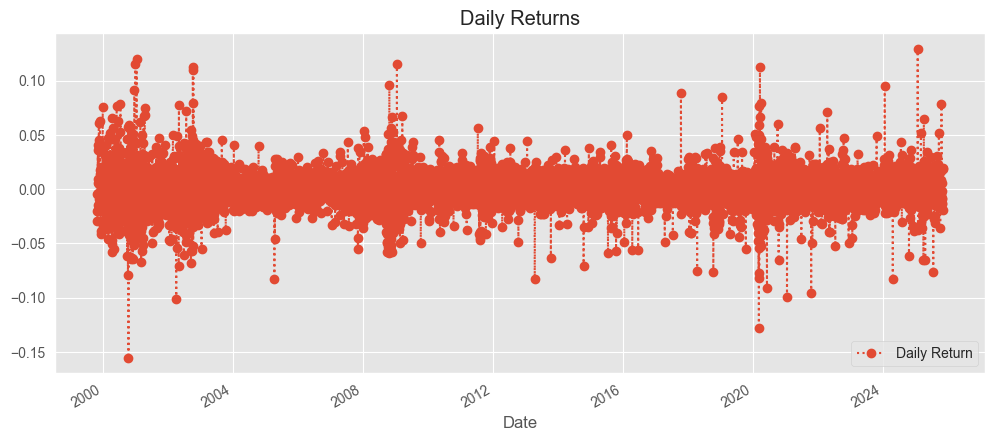

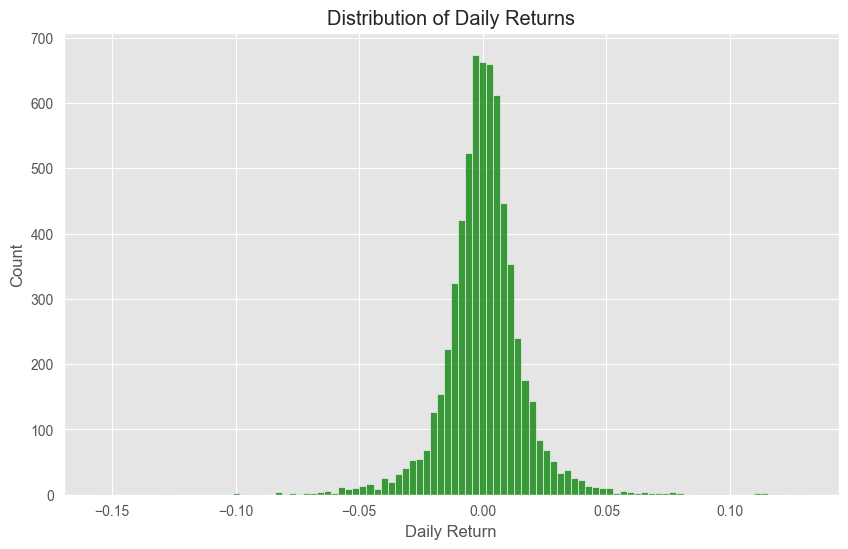


Showing Moving Averages for single-stock data


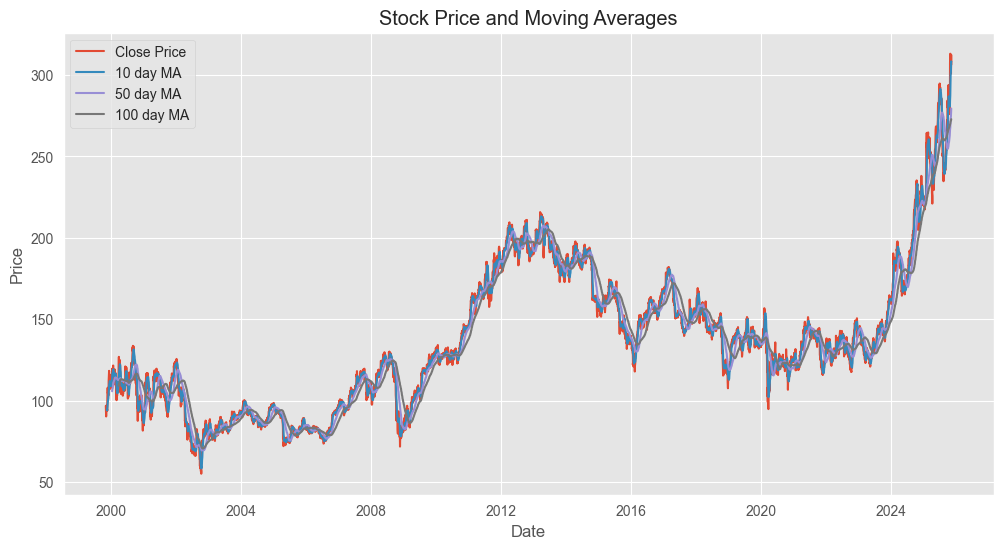


Basic Statistics:
        Unnamed: 0         open         high          low        Close  \
count  6546.000000  6546.000000  6546.000000  6546.000000  6546.000000   
mean   3272.500000   136.509333   137.769733   135.336554   136.591623   
min       0.000000    54.650000    56.700000    54.010000    55.070000   
25%    1636.250000   103.425000   105.000000   101.955000   103.325000   
50%    3272.500000   130.750000   132.105000   129.770000   130.865000   
75%    4908.750000   161.662500   162.655000   160.455025   161.785000   
max    6545.000000   312.790000   319.350000   311.410000   313.090000   
std    1889.811763    43.040107    43.306710    42.810311    43.112112   

             volume                           Date  MA for 10 days  \
count  6.546000e+03                           6546     6537.000000   
mean   5.857900e+06  2012-11-04 05:20:43.996333568      136.503439   
min    1.027500e+06            1999-11-01 00:00:00       58.263000   
25%    3.705910e+06            200

In [5]:
# Preprocessing that supports single-stock or multi-stock DataFrame
ma_day = [10,50,100]

if 'Symbol' in data.columns:
    stocks_stats = data.groupby('Symbol').agg({
        'Close': ['mean', 'std', 'min', 'max'],
        'Volume': 'mean'
    }).round(2)
    print("Stock Statistics:")
    print(stocks_stats)

    for ma in ma_day:
        column_name = f"MA for {ma} days"
        data[column_name] = data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=ma).mean())

    data['Daily Return'] = data.groupby('Symbol')['Close'].pct_change()

    # Plot average daily returns across all stocks
    plt.figure(figsize=(12,5))
    data.groupby('Date')['Daily Return'].mean().plot(legend=True,linestyle=':',marker='o')
    plt.title('Average Daily Returns Across All Stocks')
    plt.show()

else:
    # Single-stock flow
    print('Running preprocessing for single-stock data')
    for ma in ma_day:
        column_name = f"MA for {ma} days"
        data[column_name] = data['Close'].rolling(window=ma).mean()

    data['Daily Return'] = data['Close'].pct_change()

    plt.figure(figsize=(12,5))
    data.set_index('Date')['Daily Return'].plot(legend=True,linestyle=':',marker='o')
    plt.title('Daily Returns')
    plt.show()

    plt.figure(figsize=(10,6))
    sns.histplot(data=data['Daily Return'].dropna(), bins=100, color='green')
    plt.title('Distribution of Daily Returns')
    plt.show()

    sample_stock = 'data.csv'
    stock_data = data.copy()
    print(f"\nShowing Moving Averages for single-stock data")
    plt.figure(figsize=(12,6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
    for ma in ma_day:
        column_name = f"MA for {ma} days"
        plt.plot(stock_data['Date'], stock_data[column_name], label=f'{ma} day MA')
    plt.title(f'Stock Price and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

print('\nBasic Statistics:')
print(data.describe())

After that, we'll visualize the data for understanding, this is shown below...

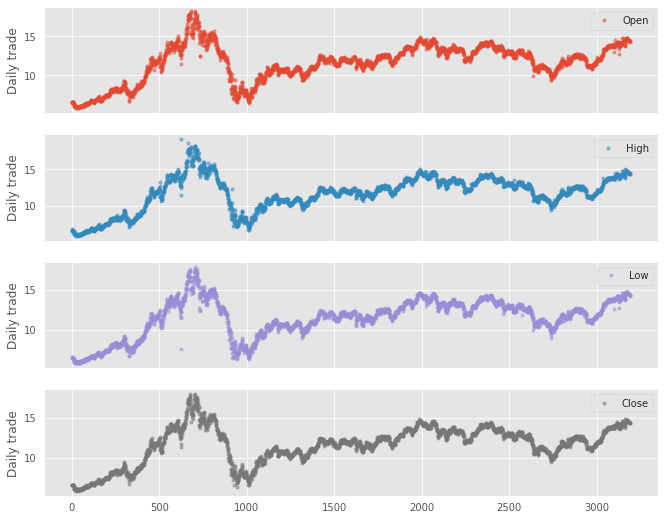

In [317]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

,count,mean,std,min,25%,50%,75%,max
Open,3190.0,11.599416,2.350376,5.860300,10.534000,11.981000,13.271000,18.130000
High,3190.0,11.712848,2.365621,5.905000,10.655000,12.067000,13.386750,19.151000
Low,3190.0,11.484610,2.327065,5.834700,10.413750,11.899000,13.189000,17.842000
Close,3190.0,11.605599,2.341989,5.841100,10.554000,11.988500,13.295750,17.925000
Volume,3190.0,28444.870846,37525.175821,106.000000,8147.750000,17741.500000,36167.250000,634041.000000
OpenInt,3190.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MA for 10 days,3190.0,11.608780,2.321162,5.963080,10.577125,11.962700,13.297200,17.329400
MA for 50 days,3190.0,11.625272,2.231059,6.037646,10.591696,11.933450,13.269480,16.618460
MA for 100 days,3190.0,11.649354,2.113346,6.221377,10.632551,11.876775,13.200810,16.042560
Daily Return,3190.0,0.000388,0.017010,-0.130345,-0.006439,0.000484,0.007807,0.150503


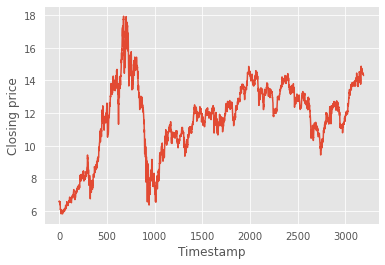

In [318]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [8]:
from sklearn.model_selection import train_test_split

# Create sequences with normalization (percentage change from first value)
def create_sequences_normalized_single(prices, window_size=100):
    X = []
    Y = []
    for i in range(len(prices) - window_size):
        first_price = prices[i]
        seq = [(prices[i + j] - first_price) / first_price for j in range(window_size)]
        target = (prices[i + window_size] - first_price) / first_price
        X.append(seq)
        Y.append(target)
    return np.array(X), np.array(Y)

# If Symbol exists use multi-stock code, otherwise single-stock
if 'Symbol' in data.columns:
    all_X = []
    all_Y = []
    for symbol in data['Symbol'].unique():
        stock_data = data[data['Symbol'] == symbol].sort_values('Date')
        if len(stock_data) <= 100:
            continue
        prices = stock_data['Close'].values
        Xs, Ys = create_sequences_normalized_single(prices)
        all_X.extend(Xs)
        all_Y.extend(Ys)
    X = np.array(all_X)
    Y = np.array(all_Y)
else:
    prices = data['Close'].values
    X, Y = create_sequences_normalized_single(prices)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Use shuffle=True and a fixed random_state
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

print('Training Data Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Data Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)
print(f'\nData range - Min: {X.min():.4f}, Max: {X.max():.4f}')
print(f'Target range - Min: {Y.min():.4f}, Max: {Y.max():.4f}')

Training Data Shape: (5156, 100, 1)
Training Labels Shape: (5156,)
Testing Data Shape: (1290, 100, 1)
Testing Labels Shape: (1290,)

Data range - Min: -0.4482, Max: 0.6085
Target range - Min: -0.3985, Max: 0.4152


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [18]:
# For creating model and training (full experiment - 40 epochs)
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, InputLayer
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create the model - keep time dimension for LSTM
model = tf.keras.Sequential([
    InputLayer(shape=(100, 1)),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(2),
    # LSTM consumes the sequence
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(50, return_sequences=False)),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# Print model summary
print(model.summary())

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the model for 40 epochs
print("\nStarting training for 40 epochs...")
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"\nTraining completed!")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"Final training MAE: {history.history['mae'][-1]:.6f}")
print(f"Final validation MAE: {history.history['val_mae'][-1]:.6f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 100, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 25, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 12, 200)        │       132,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,101 (1.10 MB)

 Trainable params: 287,101 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

None

Starting training for 40 epochs...
Epoch 1/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0035 - mae: 0.0425 - mse: 0.0035 - val_loss: 7.6728e-04 - val_mae: 0.0197 - val_mse: 7.6728e-04 - learning_rate: 0.0010
Epoch 2/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0035 - mae: 0.0425 - mse: 0.0035 - val_loss: 7.6728e-04 - val_mae: 0.0197 - val_mse: 7.6728e-04 - learning_rate: 0.0010
Epoch 2/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.3692e-04 - mae: 0.0202 - mse: 7.3692e-04 - val_loss: 4.8198e-04 - val_mae: 0.0157 - val_mse: 4.8198e-04 - learning_rate: 0.0010
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.3692e-04 - mae: 0.0202 - mse: 7.3692e-04 - val_loss: 4.8198e-04 - val_mae: 0.0157 - val_mse: 4.8198e-04 - learning_rate: 0.0010
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.0443e-04 - mae: 0.0182 - mse: 6.0443e-04 - val_loss: 3.7882e-04 - val_mae: 0.0132 - val_mse: 3.7882e-04 - learning_rate: 0.0010
Epoch 4/40
162/162 ━

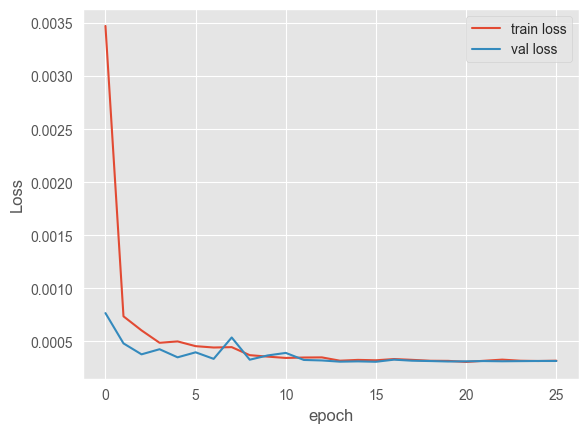

In [19]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

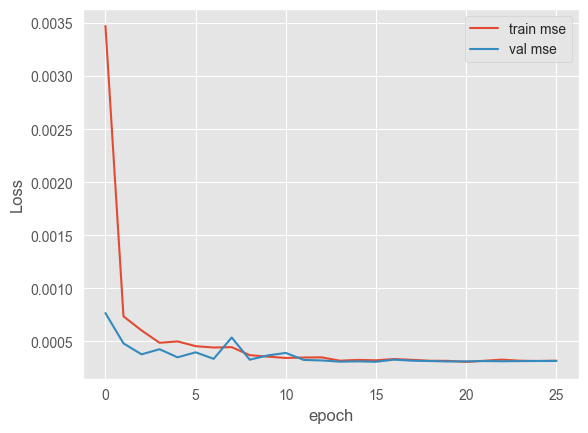

In [20]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

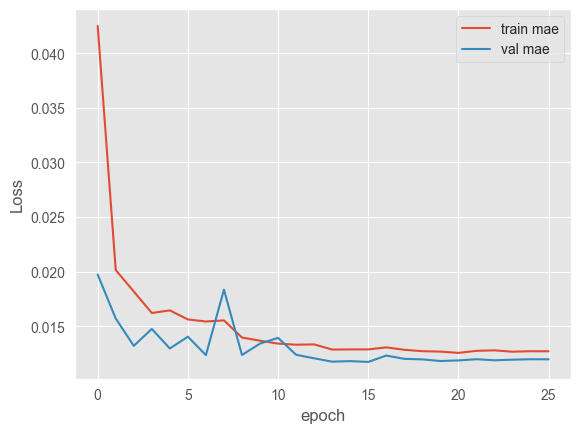

In [21]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [13]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 100, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,133 (637.24 KB)

 Trainable params: 54,377 (212.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,756 (424.83 KB)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


In [14]:
model.evaluate(test_X, test_Y)

NameError: name 'test_X' is not defined

In [15]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

NameError: name 'test_X' is not defined

In [17]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

NameError: name 'test_X' is not defined

# Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [23]:
# First we need to save a model
model.save("model.h5")

In [329]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [330]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, 1, 98, 64)         256       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 1, 49, 64)         0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 1, 47, 128)        24704     
_________________________________________________________________
time_distributed_45 (TimeDis (None, 1, 23, 128)        0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, 1, 21, 64)         24640     
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 10, 64)         0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 640)           

In [331]:
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')
data2 = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()
df2 = data2.drop('date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

      Unnamed: 0    open      high     low   close    volume
0              0  130.63  131.6500  129.95  131.62   4294499
1              1  130.00  130.9600  129.52  130.63   3649044
2              2  129.06  129.7900  127.60  129.75   3923198
3              3  127.66  129.3356  127.66  128.97   4855972
4              4  125.72  127.2000  124.70  127.06   4941411
...          ...     ...       ...     ...     ...       ...
5570        5570   92.75   92.9400   90.19   90.25  13737600
5571        5571   94.44   94.4400   90.00   91.56  16697600
5572        5572   95.87   95.9400   93.50   94.37  10369100
5573        5573   96.75   96.8100   93.69   94.81  11105400
5574        5574   98.50   98.8100   96.37   96.75   9551800

[5575 rows x 6 columns]
4378
1095


In [332]:
model.evaluate(test_X, test_Y)

35/35 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0605


[0.006102326791733503, 0.006102326791733503, 0.060518551617860794]

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Squared Error: 0.00030885258370017514
Mean Absolute Error: 0.011744434586404279
R2 Score: 0.9818982761750423
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Squared Error: 0.00030885258370017514
Mean Absolute Error: 0.011744434586404279
R2 Score: 0.9818982761750423


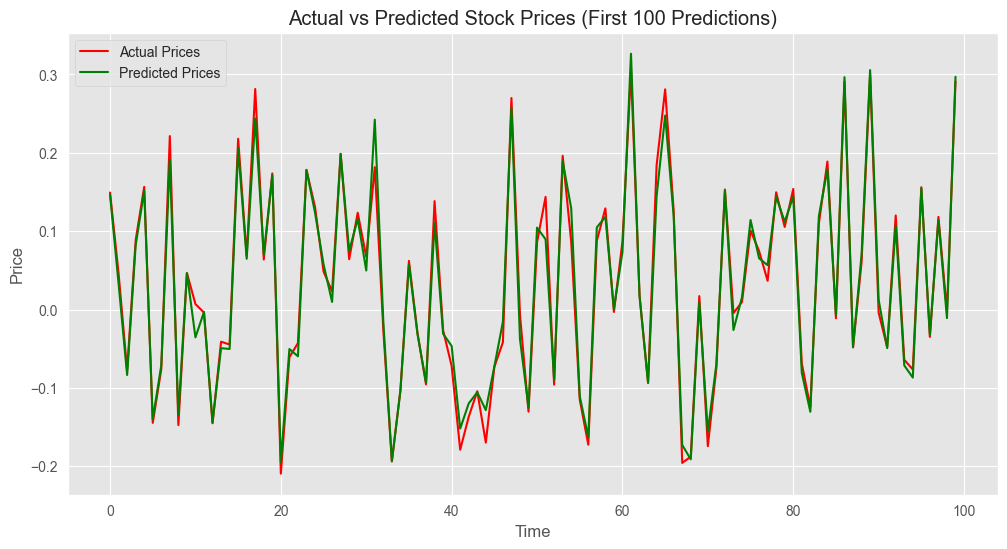

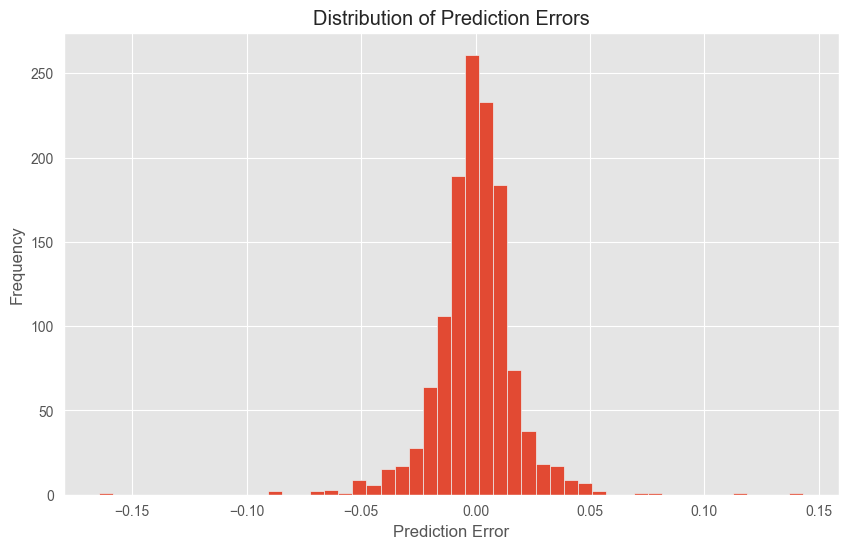

Predictions within 1.0% margin: 7.05%
Predictions within 2.0% margin: 13.49%
Predictions within 5.0% margin: 31.09%
Predictions within 10.0% margin: 53.10%


In [22]:
# Make predictions
predicted = model.predict(x_test)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R2 Score:', r2)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual Prices', color='red')
plt.plot(predicted[:100], label='Predicted Prices', color='green')
plt.title('Actual vs Predicted Stock Prices (First 100 Predictions)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot prediction error distribution
errors = y_test - predicted.flatten()
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# Calculate and print percentage of predictions within different error margins
error_margins = [0.01, 0.02, 0.05, 0.10]  # 1%, 2%, 5%, 10%
for margin in error_margins:
    within_margin = np.mean(np.abs(errors / y_test) < margin) * 100
    print(f'Predictions within {margin*100}% margin: {within_margin:.2f}%')

In [334]:
# Converting model from HDF5 format to TFJS format...
!pip install tensorflowjs[wizard]
# Need to be done on a CLI and not in notebook
!tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/model-tjs

2021-12-28 04:28:46.375653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# EDA

This section is exploratory data analysis on the dataset collected. This is just for analysing the data...

In [335]:
dataX = pd.read_csv('./data.csv')
dataY = pd.read_csv('./data.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5575 entries, 0 to 5574
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5575 non-null   int64  
 1   open        5575 non-null   float64
 2   high        5575 non-null   float64
 3   low         5575 non-null   float64
 4   close       5575 non-null   float64
 5   volume      5575 non-null   int64  
 6   date        5575 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 305.0+ KB


In [336]:
dataX.head()

,Unnamed: 0,open,high,low,close,volume,date
0,0,130.63,131.6500,129.95,131.62,4294499,2021-12-27
1,1,130.00,130.9600,129.52,130.63,3649044,2021-12-23
2,2,129.06,129.7900,127.60,129.75,3923198,2021-12-22
3,3,127.66,129.3356,127.66,128.97,4855972,2021-12-21
4,4,125.72,127.2000,124.70,127.06,4941411,2021-12-20


In [337]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,volume,date
19,19,118.62,119.610,117.53,118.50,8949795,2021-11-29
20,20,115.00,116.335,114.56,115.81,3322012,2021-11-26
21,21,116.16,117.270,116.08,116.73,3220802,2021-11-24
22,22,116.79,117.940,116.04,116.79,4914995,2021-11-23
23,23,116.00,118.810,115.19,116.47,6417218,2021-11-22
...,...,...,...,...,...,...,...
496,496,134.51,135.860,133.92,135.31,4345952,2020-01-08
497,497,133.69,134.960,133.40,134.19,3267592,2020-01-07
498,498,133.42,134.240,133.20,134.10,2421128,2020-01-06
499,499,133.57,134.860,133.56,134.34,2373470,2020-01-03


In [338]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,volume,date
501,501,132.53,134.12,132.40,134.04,3777504,2019-12-31
502,502,135.20,135.30,132.50,132.81,4118929,2019-12-30
503,503,135.00,135.75,134.87,135.27,2752185,2019-12-27
504,504,134.98,135.31,134.65,134.91,2129654,2019-12-26
505,505,135.61,135.62,134.61,134.98,1202087,2019-12-24
...,...,...,...,...,...,...,...
999,999,162.66,163.91,161.70,163.47,5101023,2018-01-08
1000,1000,162.44,162.90,161.10,162.49,5162075,2018-01-05
1001,1001,159.65,162.32,159.37,161.70,7363843,2018-01-04
1002,1002,157.34,159.81,156.33,158.49,9439063,2018-01-03


In [339]:
dataX.describe()

,Unnamed: 0,open,high,low,close,volume
count,482.000000,482.000000,482.000000,482.000000,482.000000,4.820000e+02
mean,259.500000,129.382080,130.691720,128.092867,129.364751,5.454950e+06
std,139.285678,11.382857,11.114856,11.592091,11.353678,3.339331e+06
min,19.000000,94.600000,97.740000,90.560000,94.770000,1.761122e+06
25%,139.250000,121.250000,122.623500,120.102500,121.105000,3.644222e+06
50%,259.500000,126.325000,127.320000,125.045000,126.160000,4.655173e+06
75%,379.750000,139.672500,140.467500,138.757500,139.572500,6.115408e+06
max,500.000000,156.820000,158.750000,155.420000,156.760000,3.806353e+07


In [340]:
dataY.describe()

,Unnamed: 0,open,high,low,close,volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,752.000000,140.470239,141.512740,139.348929,140.416143,4.590926e+06
std,145.347859,11.156349,11.144803,11.149435,11.121441,2.880224e+06
min,501.000000,108.000000,111.000000,105.940000,107.570000,1.202087e+06
25%,626.500000,134.485000,135.305000,133.570000,134.360000,3.067226e+06
50%,752.000000,140.720000,141.780000,139.790000,140.850000,3.783614e+06
75%,877.500000,146.635000,147.300000,145.540000,146.385000,5.033500e+06
max,1003.000000,170.000000,171.130000,168.150000,169.120000,2.206367e+07


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


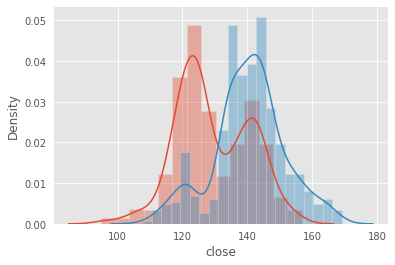

In [341]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

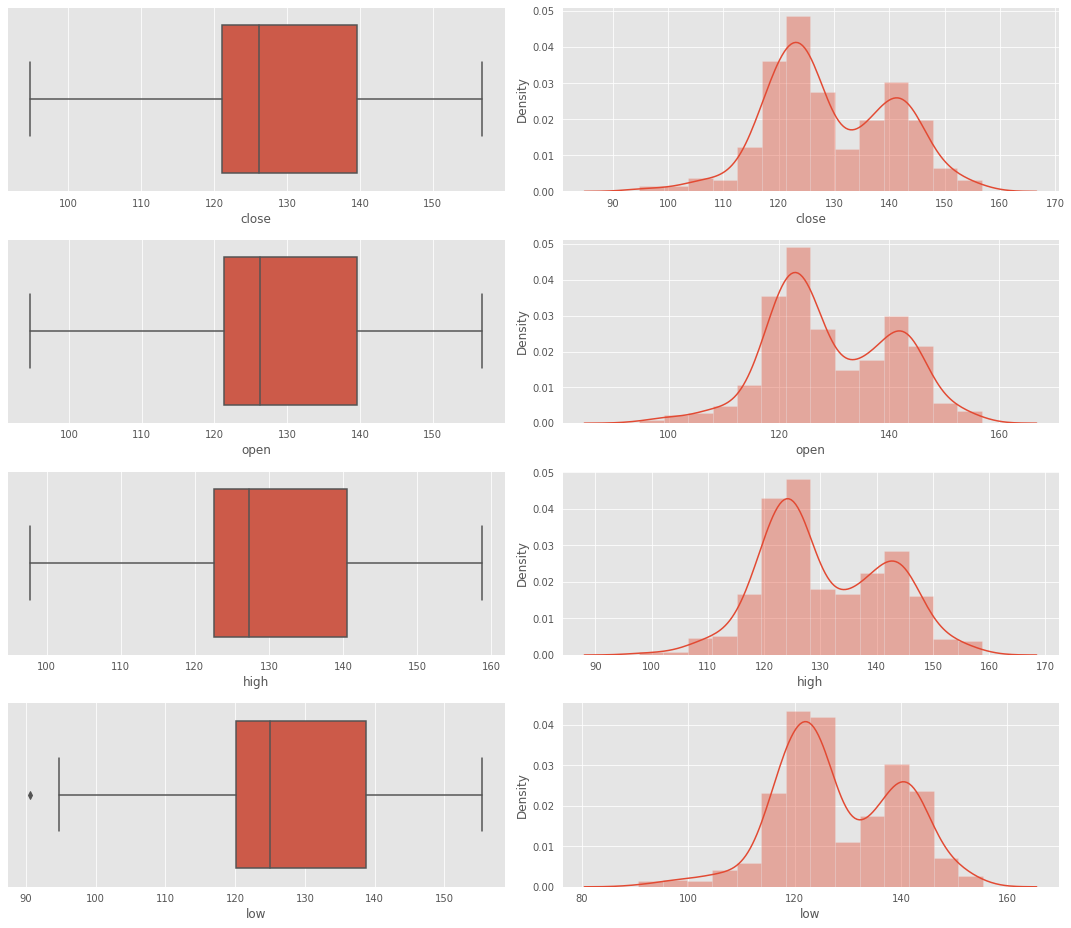

In [342]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

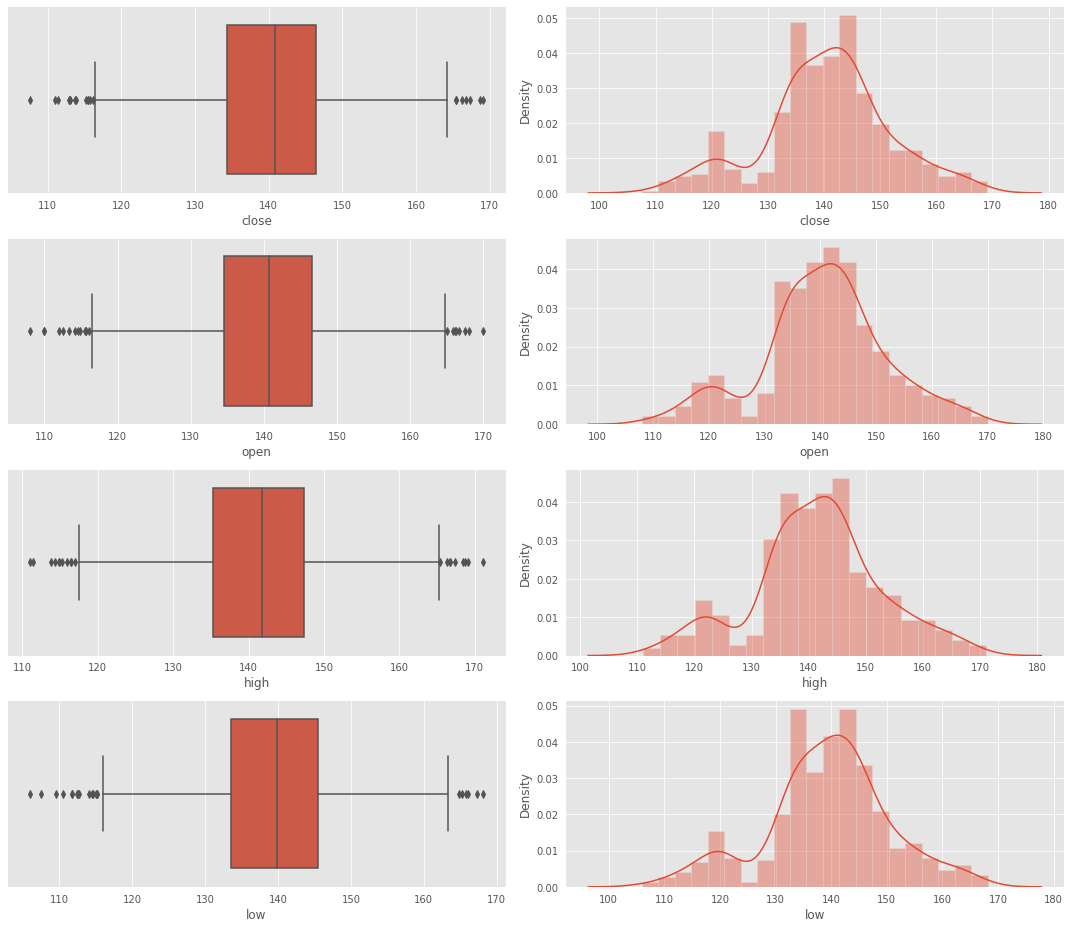

In [343]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

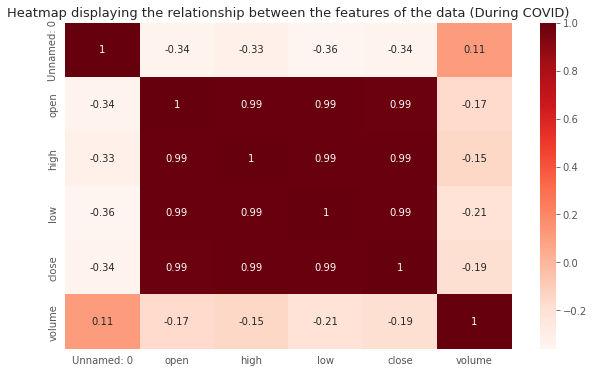

In [344]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

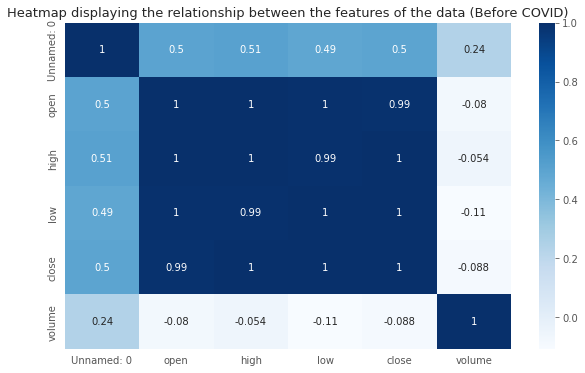

In [345]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()

In [346]:
# For other company....

# UNCOMMENT IF NEEDED...
#cv2 = request_stock_price_list('RELIANCE.BSE', 'full', key)
#print(cv2.head)
#cv2.to_csv('data2.csv')

dataX = pd.read_csv('./data2.csv')
dataY = pd.read_csv('./data2.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4184 entries, 0 to 4183
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4184 non-null   int64  
 1   open        4184 non-null   float64
 2   high        4184 non-null   float64
 3   low         4184 non-null   float64
 4   close       4184 non-null   float64
 5   volume      4184 non-null   int64  
 6   date        4184 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 228.9+ KB


In [347]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,volume,date
20,20,2412.0000,2500.0000,2400.0000,2442.5000,451870,2021-11-29
21,21,2470.0000,2477.4500,2403.0000,2412.1499,397321,2021-11-26
22,22,2375.5000,2502.8000,2358.0000,2494.3999,476931,2021-11-25
23,23,2381.3999,2410.8501,2344.0000,2350.8999,1856369,2021-11-24
24,24,2339.0000,2401.5000,2309.3999,2386.1499,457139,2021-11-23
...,...,...,...,...,...,...,...
489,489,1519.9995,1533.9995,1514.4495,1525.0495,509038,2020-01-07
490,490,1526.9995,1527.9995,1497.4995,1501.4995,457443,2020-01-06
491,491,1534.3995,1541.2995,1523.3995,1537.2495,357456,2020-01-03
492,492,1513.9995,1540.7995,1512.9995,1535.3495,733200,2020-01-02


In [348]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,volume,date
493,493,1516.0995,1527.3995,1505.3495,1509.6995,461171,2020-01-01
494,494,1544.6995,1544.6995,1509.0995,1514.0995,298520,2019-12-31
495,495,1542.9995,1546.9995,1528.2995,1544.1995,374974,2019-12-30
496,496,1524.9995,1545.7995,1521.4495,1542.1495,490080,2019-12-27
497,497,1545.9495,1553.2995,1510.9495,1515.9495,582675,2019-12-26
...,...,...,...,...,...,...,...
978,978,920.4997,925.8497,919.4497,922.9997,410556,2018-01-05
979,979,918.9997,921.7997,915.9997,920.2497,241196,2018-01-04
980,980,924.4497,927.1997,913.2997,916.3497,520663,2018-01-03
981,981,914.9997,919.1997,907.2497,911.3997,1779802,2018-01-02


In [349]:
dataX.describe()

,Unnamed: 0,open,high,low,close,volume
count,474.000000,474.000000,474.000000,474.000000,474.000000,4.740000e+02
mean,256.500000,1953.239692,1977.124080,1925.387901,1949.614691,1.148593e+06
std,136.976275,378.827940,377.669256,377.601744,377.490721,6.773073e+06
min,20.000000,919.999700,951.999700,875.699700,883.849700,6.484700e+04
25%,138.250000,1731.837500,1754.662500,1714.137500,1729.987500,2.998212e+05
50%,256.500000,2013.850000,2045.550000,1990.925000,2007.300000,4.758745e+05
75%,374.750000,2170.825000,2194.675000,2139.500000,2167.175000,9.260610e+05
max,493.000000,2740.000000,2750.000000,2708.000000,2731.500000,1.187279e+08


In [350]:
dataY.describe()

,Unnamed: 0,open,high,low,close,volume
count,490.00000,490.000000,490.000000,490.000000,490.000000,4.900000e+02
mean,737.50000,1182.485761,1194.496168,1168.685966,1181.144638,5.672558e+05
std,141.59508,185.207018,186.587684,182.842687,184.419946,5.363404e+05
min,493.00000,879.999700,895.999700,872.099700,882.799700,1.488160e+05
25%,615.25000,999.624700,1012.524700,990.762200,1002.462200,3.096382e+05
50%,737.50000,1207.499600,1223.449600,1195.999600,1210.324600,4.345385e+05
75%,859.75000,1297.999600,1314.699600,1283.862100,1296.824600,6.224218e+05
max,982.00000,1611.199500,1617.799500,1595.649500,1605.149500,6.718394e+06


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


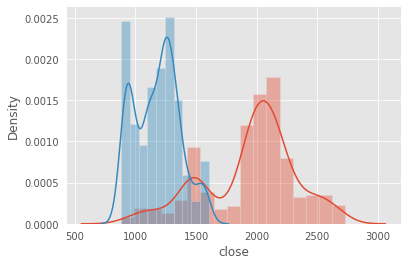

In [351]:
sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

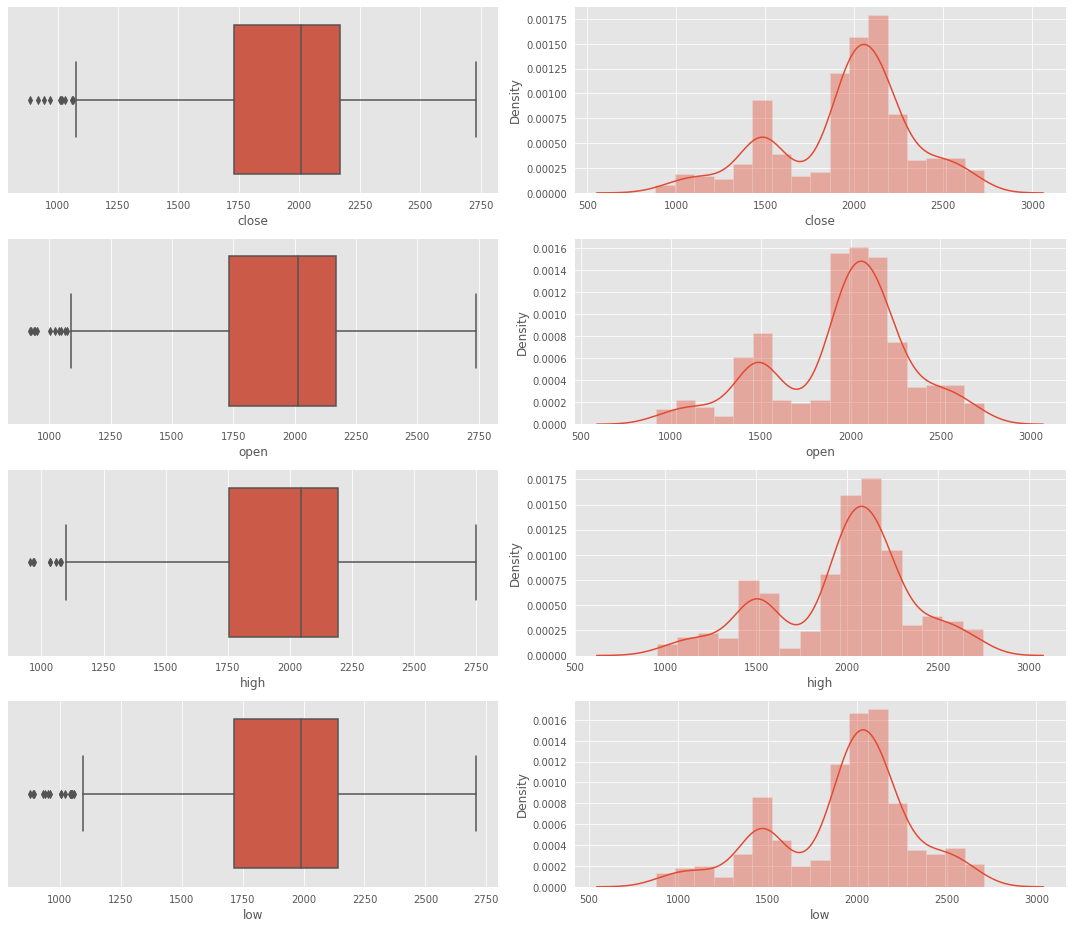

In [352]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

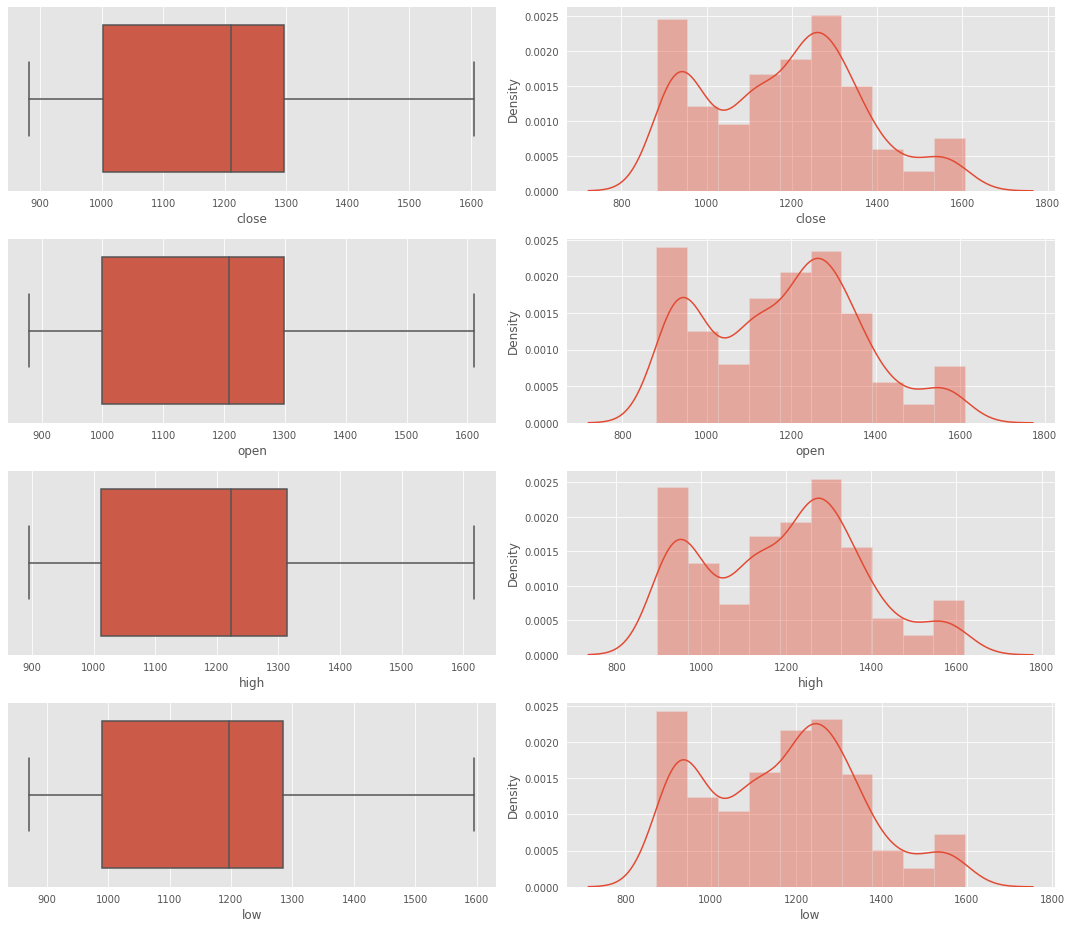

In [353]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

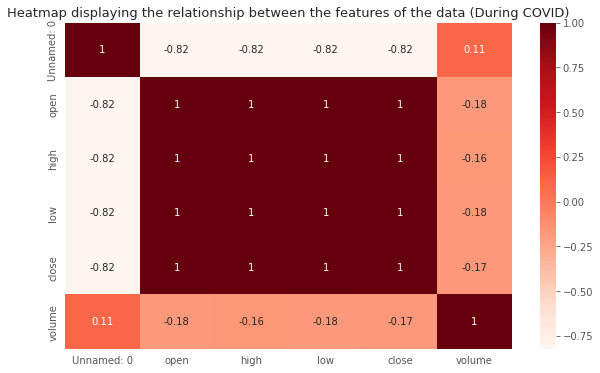

In [354]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

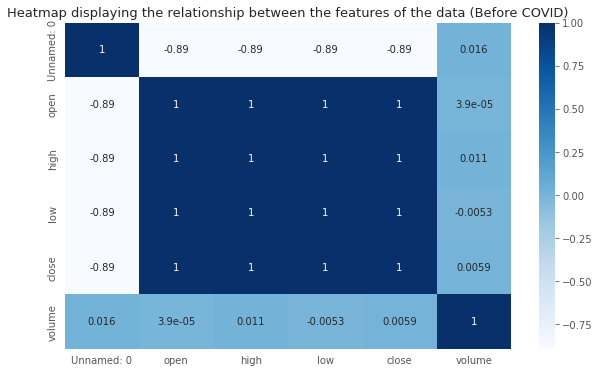

In [355]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()